# Reward competition distance from port analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
from datetime import datetime
from functools import reduce
import ast

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.signal import savgol_filter

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = "./proc" # where data is saved should always be shown in the inputs
# ITIs from MED-PC code
FRAME_RATE = 30
ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
# Converting the seconds into frames
ALL_ITIS = [num * FRAME_RATE for num in ALL_ITIS]
MEDPC_BOX_WIDTH = 29.5
MEDPC_BOX_LENGTH = 24
FRAME_RANGE = 20 * FRAME_RATE
VELOCITY_WINDOW_SIZE = FRAME_RATE
ROLLING_AVERAGE_WINDOW_SIZE = FRAME_RATE // 2
ALL_TRIAL_NUMBERS = 19

In [5]:
TONE_START_DF = pd.read_excel("../../data/pilot_3/reward_competition/reward_comp_tone_sleap_frames.xlsx")

In [6]:
ALL_CORNER_H5 = glob.glob("../../data/pilot_3/reward_competition/corner_labeling/*corner.h5")

In [7]:
ALL_POSE_ESTIMATION_H5 = glob.glob("../../data/pilot_3/reward_competition/sleap_pose_tracking/*.h5")

In [8]:
REWARD_COMP_SCORING_DF = pd.read_csv("../2023_09_18_pilot_3_elo_rating_calculation/proc/elo_rating_spread_sheets/reward_competition/reward_competition_all_competition_cage_1_2_3_4_5_6_date_20221003_20221004.csv")

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

In [9]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names



In [10]:

def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

In [11]:

def extract_sleap_data_from_h5(filename: str) -> tuple:
    """
    Extract relevant SLEAP data from an h5 file.

    Given a filename for an h5 file, this function retrieves:
    - locations of the tracks,
    - names of the nodes,
    - names of the tracks.

    Parameters:
    - filename (str): The path to the h5 file.

    Returns:
    - tuple: A tuple containing:
      * locations (numpy.ndarray): Array of track locations.
      * node_names (list[str]): List of node names.
      * track_names (list[str]): List of track names.

    Example:
    >>> locations, node_names, track_names = extract_sleap_data_from_h5("path/to/file.h5")
    """

    with h5py.File(filename, "r") as f:
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    
    return locations, node_names, track_names

In [12]:
def interpolate_missing_coords(data: np.ndarray, method: str = "linear") -> np.ndarray:
    """
    Interpolate missing values in the provided multi-dimensional data.

    This function is designed to handle data where the first dimension represents different data points,
    and the remaining dimensions (flattened) represent different features. Interpolation is applied to each feature
    independently to fill missing values.

    Parameters:
    - data (np.ndarray): The input data with potential missing values.
    - method (str, optional): The interpolation method to be used. Default is 'linear'.

    Returns:
    - np.ndarray: The data with missing values interpolated.

    Example:
    >>> filled_data = interpolate_missing_coords(np.array([[1, np.nan, 3], [4, 5, 6]]))
    """

    # Store initial shape for later reshaping.
    initial_shape = data.shape

    # Reshape data: flatten dimensions beyond the first one.
    data = data.reshape((initial_shape[0], -1))

    # Interpolate along each column (which represents a flattened dimension of the original data).
    for i in range(data.shape[-1]):
        column_data = data[:, i]

        # Indices of valid (non-NaN) data points.
        valid_indices = np.flatnonzero(~np.isnan(column_data))

        # Build the interpolant function.
        interpolant = interp1d(valid_indices, 
                               column_data[valid_indices], 
                               kind=method, 
                               fill_value=np.nan, 
                               bounds_error=False)

        # Indices of missing (NaN) data points.
        missing_indices = np.flatnonzero(np.isnan(column_data))

        # Fill missing values using the interpolant.
        column_data[missing_indices] = interpolant(missing_indices)

        # Handle any remaining NaNs due to them being outside the valid range.
        nan_mask = np.isnan(column_data)
        column_data[nan_mask] = np.interp(np.flatnonzero(nan_mask), 
                                          valid_indices, 
                                          column_data[valid_indices])

        # Save the updated column data back.
        data[:, i] = column_data

    # Restore original data shape.
    data = data.reshape(initial_shape)

    return data

In [13]:
def scale_sleap_coordinates(row, 
                            coord_col: str, 
                            height_ratio_col: str = "height_ratio", 
                            width_ratio_col: str = "width_ratio") -> np.ndarray:
    """
    Scale SLEAP track coordinates based on provided height and width ratios.

    This function scales the x-coordinates using the width ratio and the y-coordinates using the height ratio.

    Parameters:
    - row (pd.Series): A row from a pandas DataFrame containing SLEAP track data and scaling ratios.
    - coord_col (str): The column name containing the track coordinates.
    - height_ratio_col (str, optional): The column name containing the height scaling ratio. Default is "height_ratio".
    - width_ratio_col (str, optional): The column name containing the width scaling ratio. Default is "width_ratio".

    Returns:
    - np.ndarray: The scaled coordinates.
    """

    x_coords_scaled = row[coord_col][:,:,0] * row[width_ratio_col]
    y_coords_scaled = row[coord_col][:,:,1] * row[height_ratio_col]

    return np.dstack((x_coords_scaled, y_coords_scaled))

In [14]:
def get_filtered_trials(x, index_col, data_col):
    """
    Return data from the specified data column based on the valid indices from the index column.

    Parameters:
    - x (pd.Series): A row of a DataFrame.
    - index_col (str): The name of the column containing the indices.
    - data_col (str): The name of the column containing the data to be indexed.

    Returns:
    - np.array: An array of the filtered data.
    """
    valid_indices = [i for i in x[index_col] if i < len(x[data_col])]
    return x[data_col][valid_indices]

In [15]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [16]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [17]:
def calculate_distance_between_subjects(group, column="pose_estimation_thorax_coordinates"):
    """
    This function calculates the Euclidean distance between the first two rows within each group
    based on a specified column containing coordinates.
    
    Parameters:
    group (pd.DataFrame): The group of rows on which to perform the operation.
    column (str): The column containing the coordinates to calculate the distance. Default is "pose_estimation_thorax_coordinates".

    Returns:
    np.array: An array containing the calculated distances.
    """
    if column not in group.columns:
        raise ValueError(f"The specified column '{column}' does not exist in the DataFrame.")

    if group[column].shape[0] < 2:
        raise ValueError("The group must contain at least two rows to calculate the distance.")

    return np.linalg.norm(group[column].iloc[0] - group[column].iloc[1], axis=1)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting the file name as opposed to the whole path

In [18]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain
0,10-03-22_Test_1_1-1v1-2,2135,30,C57
1,10-03-22_Test_2_1-3v1-4,2123,29,C57
2,10-03-22_Test_3_2-1v2-2,2125,29,C57
3,10-03-22_Test_13_2-2v2-4,2138,30,C57
4,10-03-22_Test_14_2-1v2-3,2127,29,C57


- Removing "fixed" as part of the file name

In [19]:
TONE_START_DF["file_base"] = TONE_START_DF["File Name"].apply(lambda x: x.split(".")[0])

- Getting the date based on the file base

In [20]:
TONE_START_DF["date"] = TONE_START_DF["file_base"].apply(lambda x: datetime.strptime(x.split("_")[0].strip(""), '%m-%d-%y').strftime('%Y-%m-%d'))



In [21]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03


- Getting the subject name from the file name

In [22]:
TONE_START_DF["all_subj"] = TONE_START_DF["file_base"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v")))

- Replacing the hyphen with a period so that we have a shared ID across datasets

In [23]:
TONE_START_DF["all_subj"] = TONE_START_DF["all_subj"].apply(lambda x: tuple([subj.replace("-", ".").strip() for subj in x]))

In [24]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03,"(2.2, 2.4)"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03,"(2.1, 2.3)"


- Making separate rows for each subject

In [25]:
TONE_START_DF["subj_id"] = TONE_START_DF["all_subj"]

In [26]:
TONE_START_DF = TONE_START_DF.explode(column="subj_id")

In [27]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1


- Getting the index of the subject from the tuple of both subjects

In [28]:
TONE_START_DF["subj_index"] = TONE_START_DF.apply(lambda x: list(x["all_subj"]).index(x["subj_id"]), axis=1)

In [29]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0


- Dropping all rows that don't have numbers for frame start

In [30]:
TONE_START_DF = TONE_START_DF[TONE_START_DF["Frame Start"].astype(str).str.isnumeric()]

In [31]:
TONE_START_DF["Frame Start"] = TONE_START_DF["Frame Start"].astype(int)

In [32]:
TONE_START_DF["all_tone_frame"] = TONE_START_DF.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

In [33]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."


# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [34]:
ALL_CORNER_H5[:5]

['../../data/pilot_3/reward_competition/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5',
 '../../data/pilot_3/reward_competition/corner_labeling/10-03-22_Test_15_1-2v1-4.fixed.corner.h5',
 '../../data/pilot_3/reward_competition/corner_labeling/10-04-22_Test_19_4-1v4-3.fixed.corner.h5',
 '../../data/pilot_3/reward_competition/corner_labeling/10-04-22_Test_15_6-1v6-3.fixed.corner.h5',
 '../../data/pilot_3/reward_competition/corner_labeling/10-04-22_Test_11_1-1v1-4.fixed.corner.h5']

In [35]:
ALL_POSE_ESTIMATION_H5[:5]

['../../data/pilot_3/reward_competition/sleap_pose_tracking/10-03-22_Test_7_4-1v4-2.fixed.analysis.h5',
 '../../data/pilot_3/reward_competition/sleap_pose_tracking/10-04-22_Test_8_3-2v3-3.fixed.analysis.h5',
 '../../data/pilot_3/reward_competition/sleap_pose_tracking/10-03-22_Test_8_4-3v4-4.fixed.analysis.h5',
 '../../data/pilot_3/reward_competition/sleap_pose_tracking/10-03-22_Test_19_3-2v3-4.fixed.analysis.h5',
 '../../data/pilot_3/reward_competition/sleap_pose_tracking/10-04-22_Test_16_6-2v6-4.fixed.analysis.h5']

In [36]:
len(ALL_CORNER_H5)

33

In [37]:
len(ALL_POSE_ESTIMATION_H5)

33

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [38]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in ALL_CORNER_H5}

In [39]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in ALL_POSE_ESTIMATION_H5}

In [40]:
file_name_to_corner[list(file_name_to_corner.keys())[0]]

'../../data/pilot_3/reward_competition/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5'

In [41]:
TONE_START_DF["corner_file"] = TONE_START_DF["file_base"].map(file_name_to_corner)
TONE_START_DF["pose_estimation_file"] = TONE_START_DF["file_base"].map(file_name_to_pose_estimation)

In [42]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...


- Function that gets the SLEAP data

In [43]:
corner_node_names = extract_sleap_data_from_h5(ALL_CORNER_H5[0])[1]

In [44]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

- Getting the coordinates of each corner and the reward port

In [45]:
TONE_START_DF["corner_sleap"] = TONE_START_DF["corner_file"].apply(lambda x: extract_sleap_data_from_h5(x))

In [46]:
for index, node in enumerate(corner_node_names):
    TONE_START_DF["{}_coordinates".format(node)] = TONE_START_DF["corner_file"].apply(lambda x: extract_sleap_data_from_h5(x)[0][0,index,:,0])

In [47]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file,corner_sleap,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...,"([[[[390.9854761 ]\n [550.10455014]], [[513.88...","[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...,"([[[[390.9854761 ]\n [550.10455014]], [[513.88...","[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...,"([[[[351.04978404]\n [626.27280513]], [[519.57...","[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...,"([[[[351.04978404]\n [626.27280513]], [[519.57...","[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",../../data/pilot_3/reward_competition/corner_l...,../../data/pilot_3/reward_competition/sleap_po...,"([[[[336.35679625]\n [588.63682422]], [[508.91...","[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"


- Plotting the coordinates of the corners to verify

In [48]:
corner_columns = [col for col in TONE_START_DF.columns if "coordinates" in col]

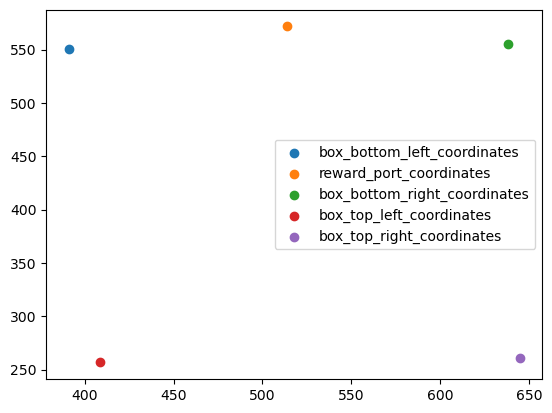

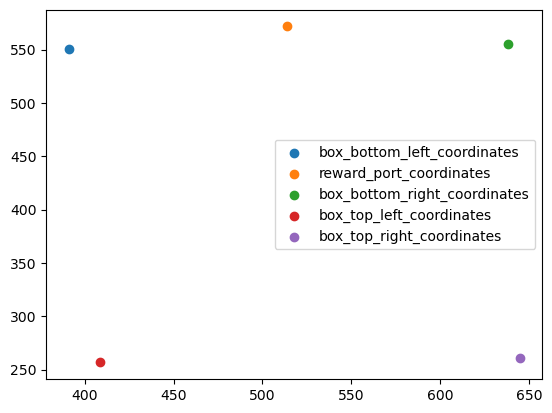

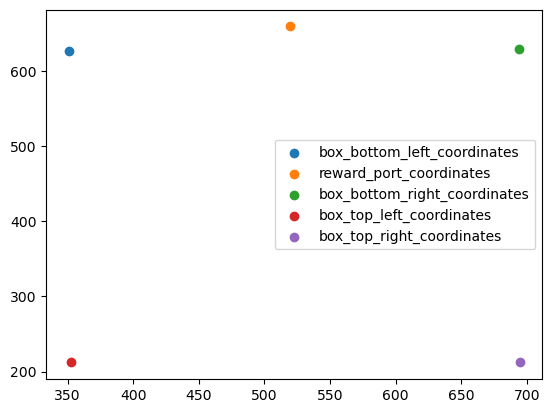

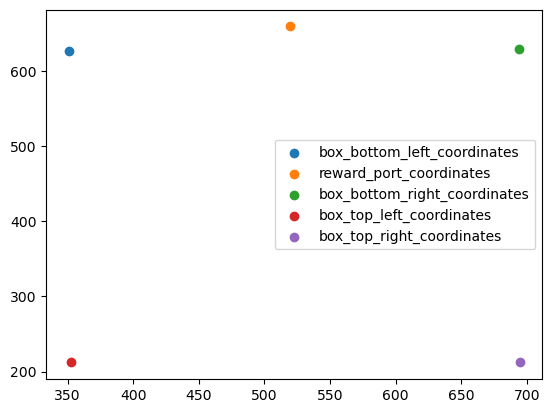

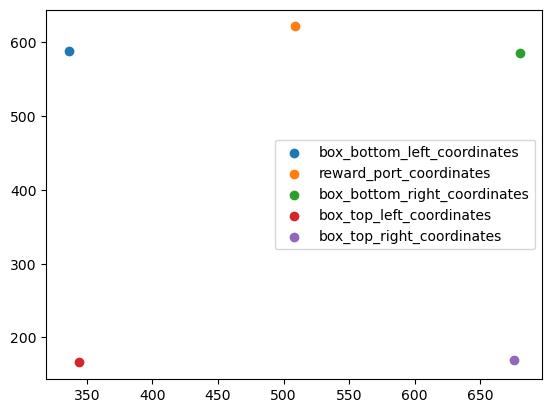

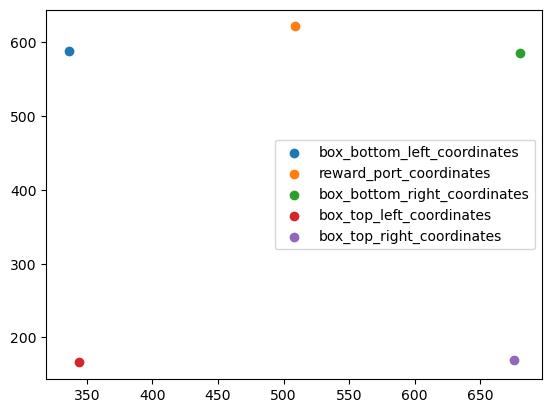

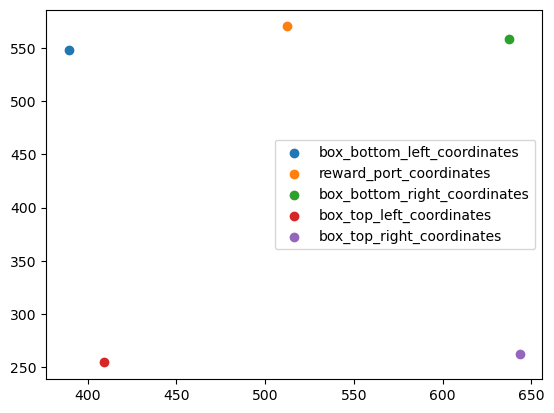

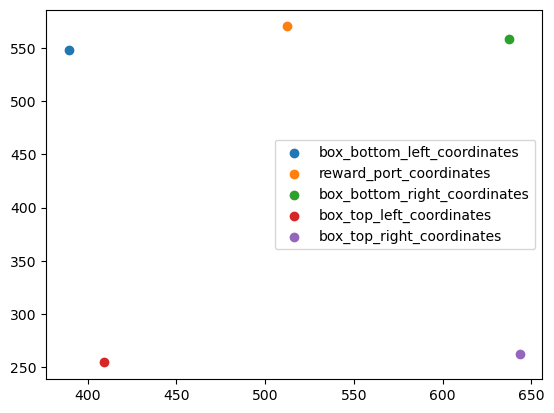

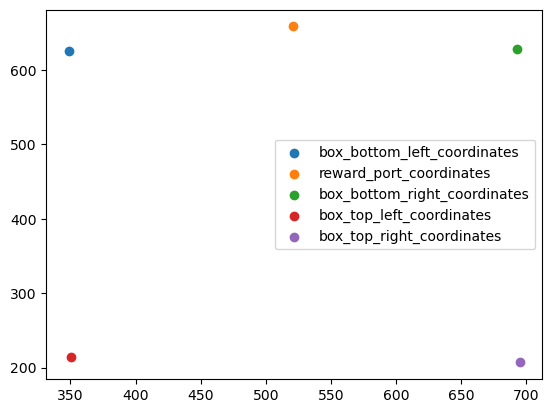

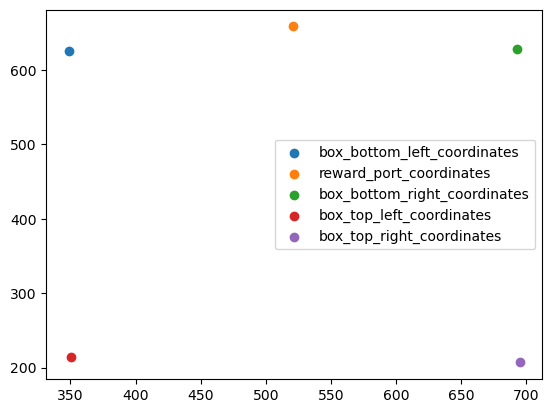

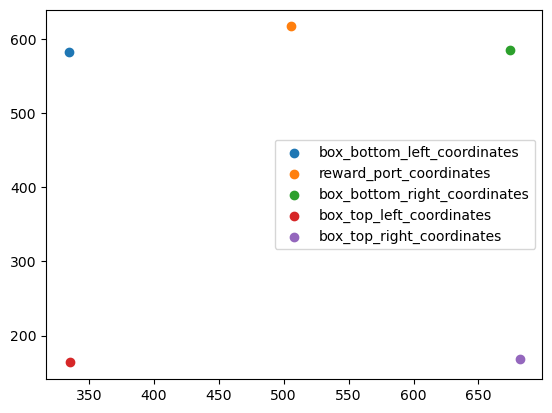

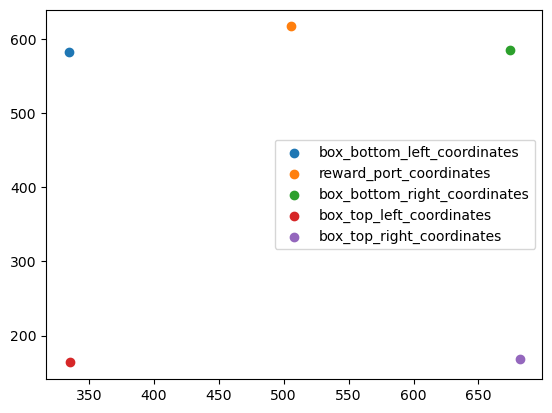

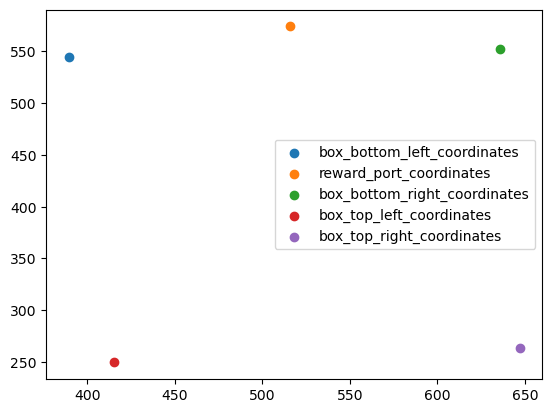

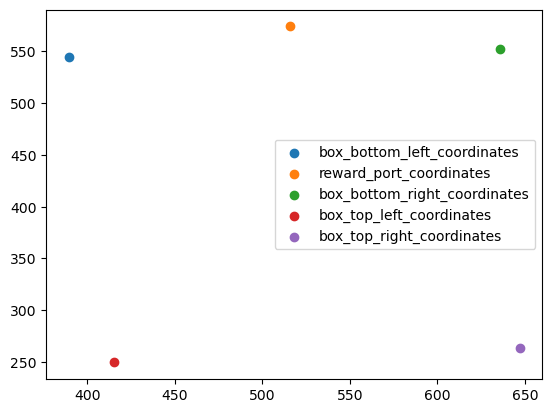

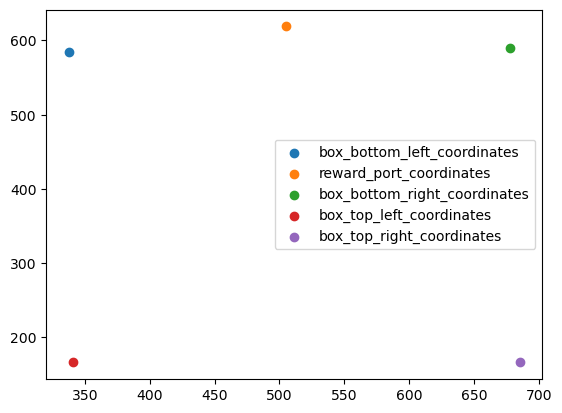

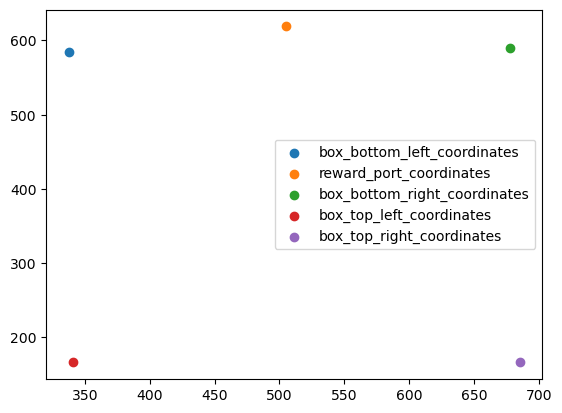

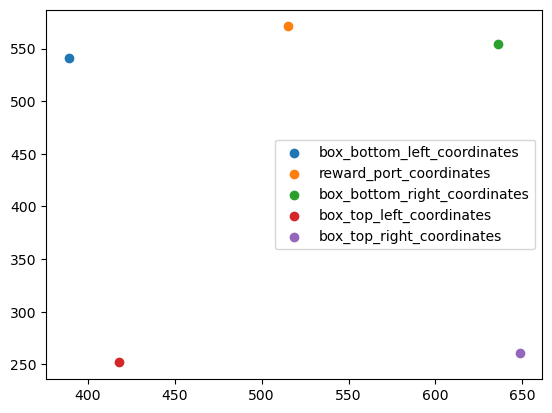

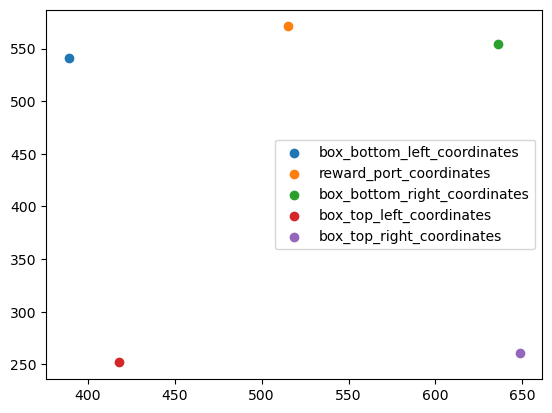

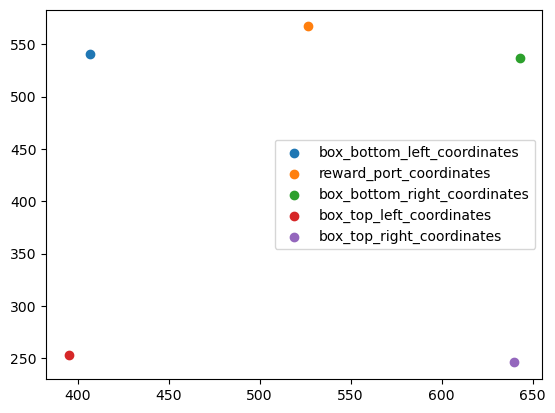

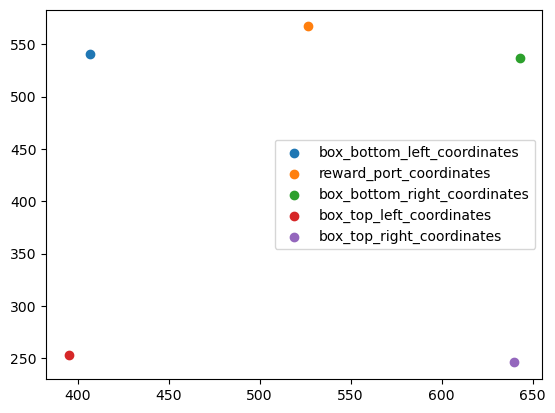

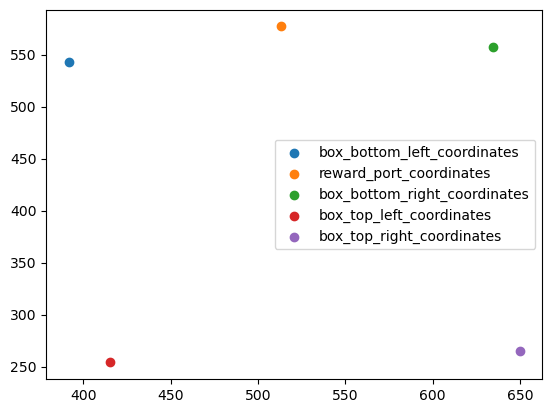

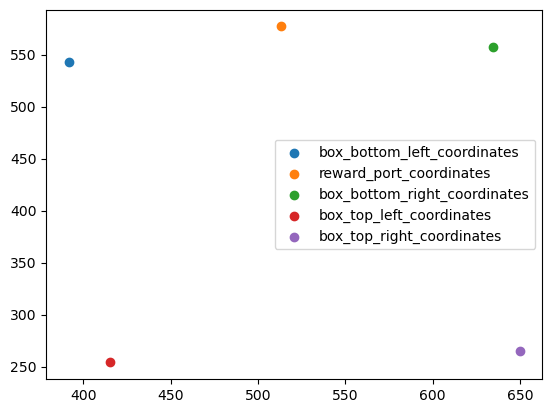

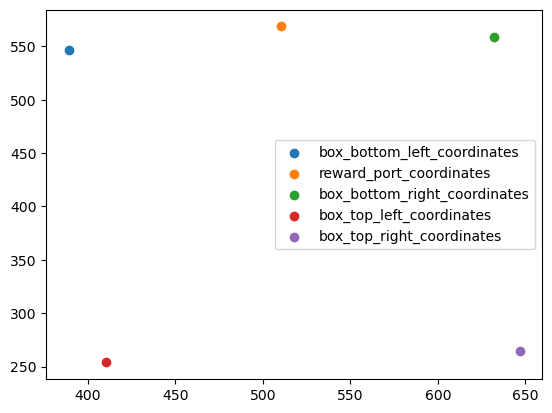

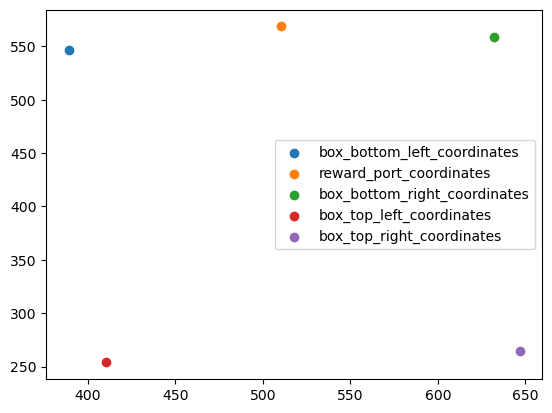

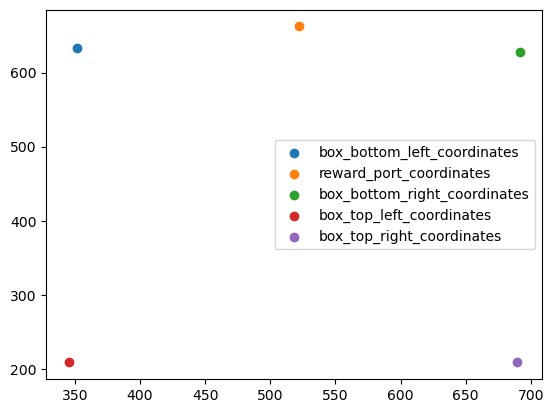

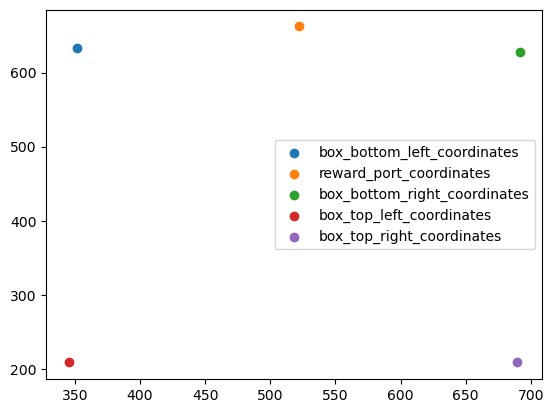

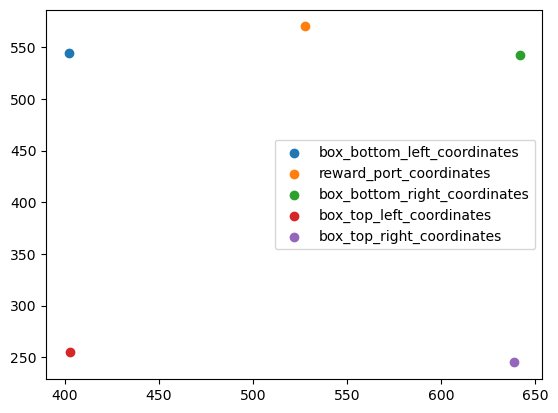

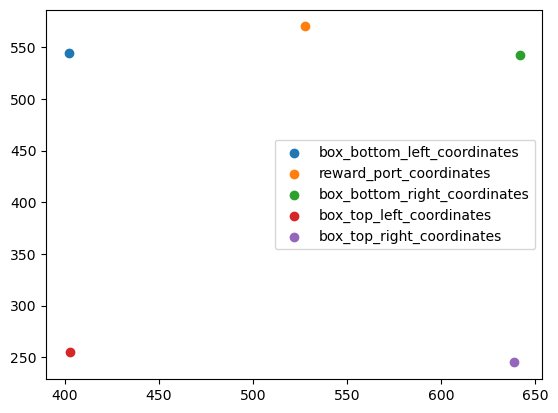

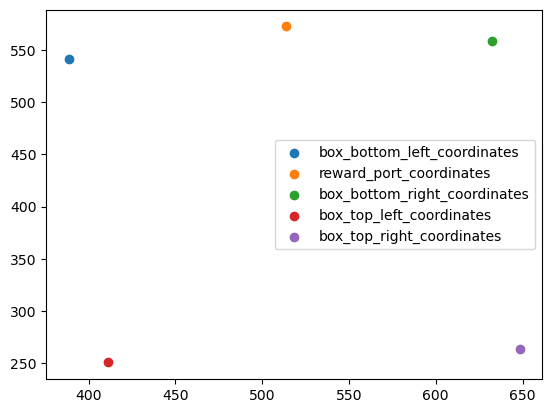

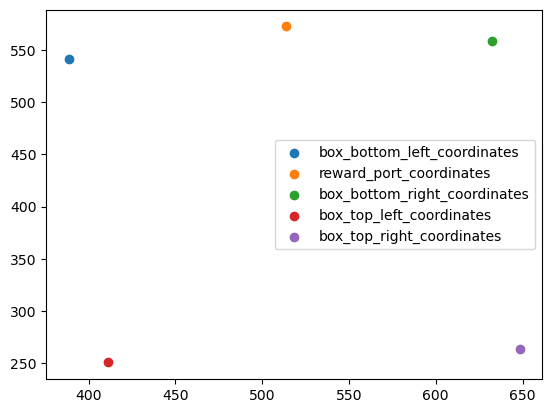

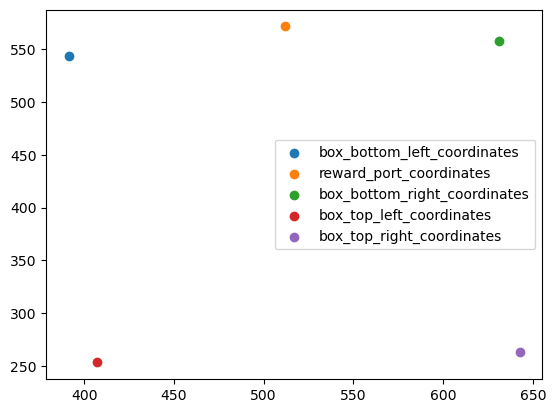

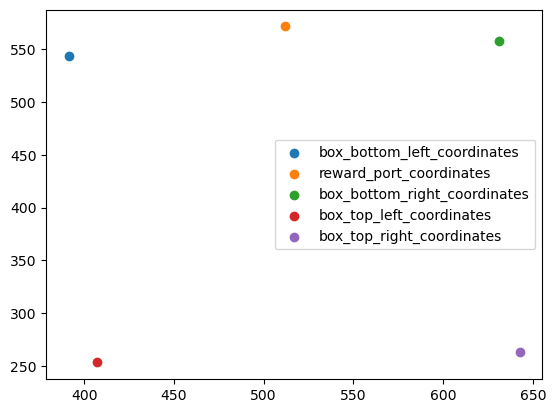

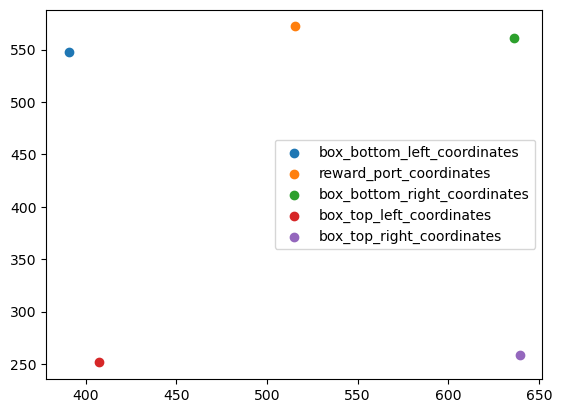

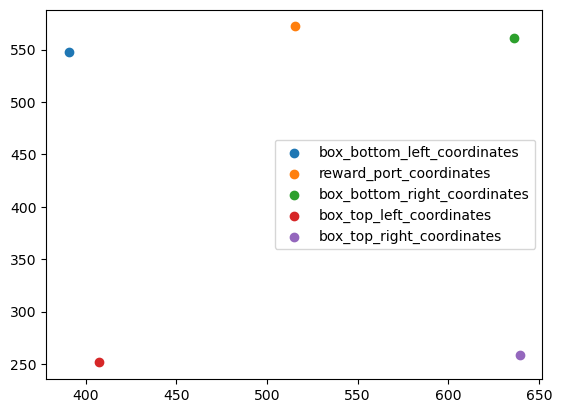

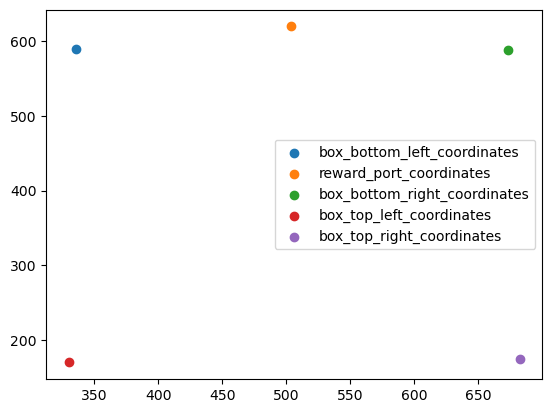

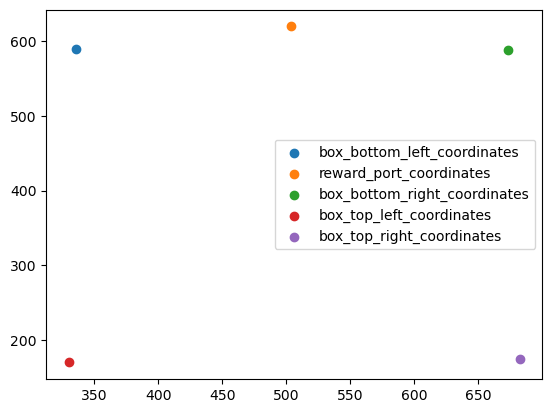

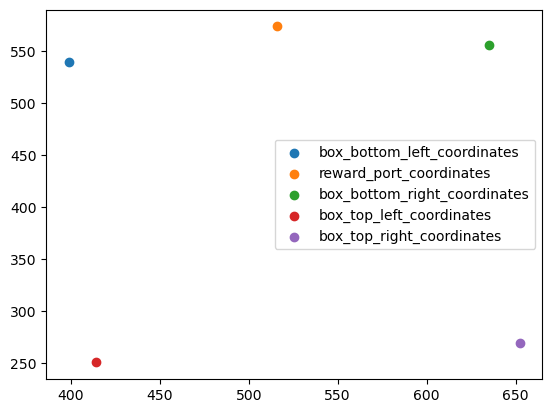

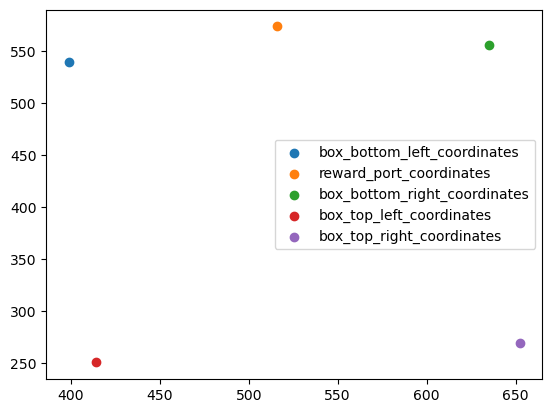

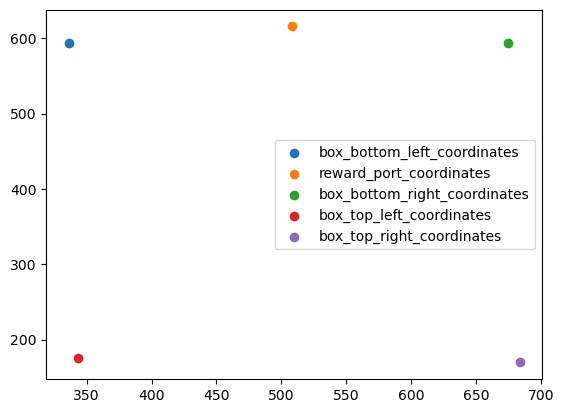

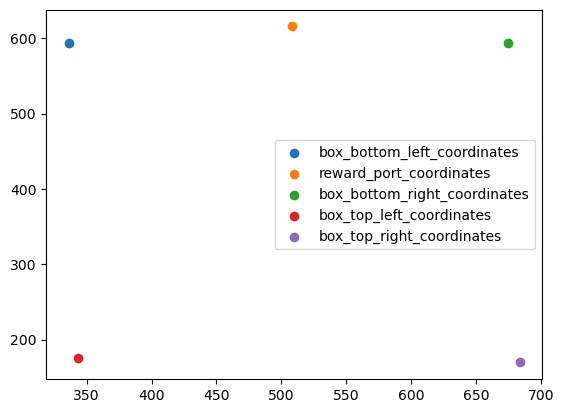

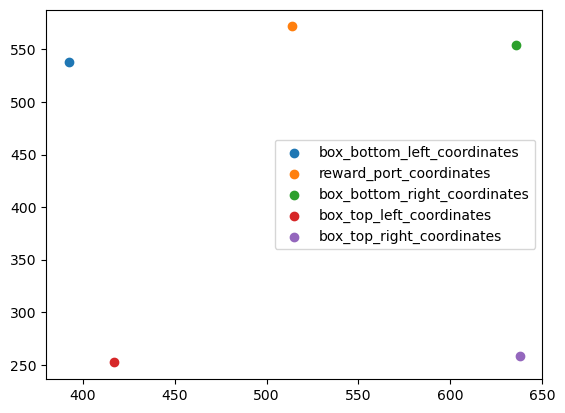

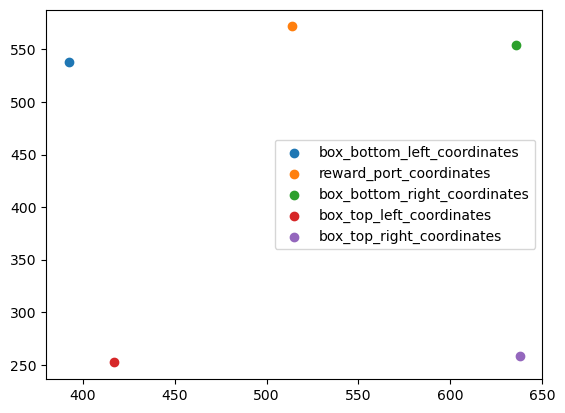

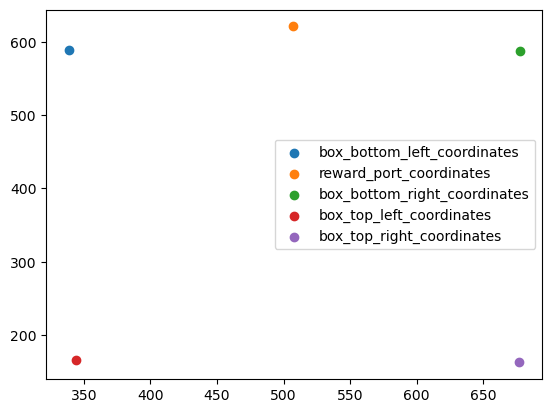

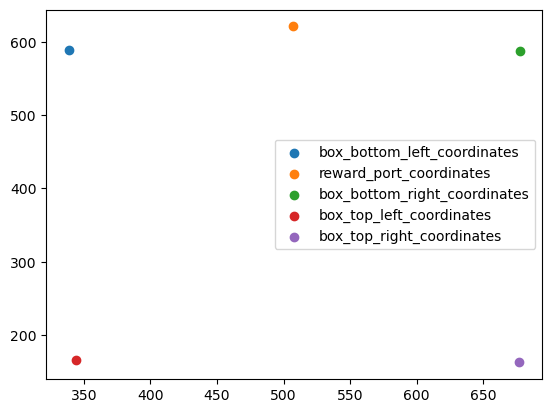

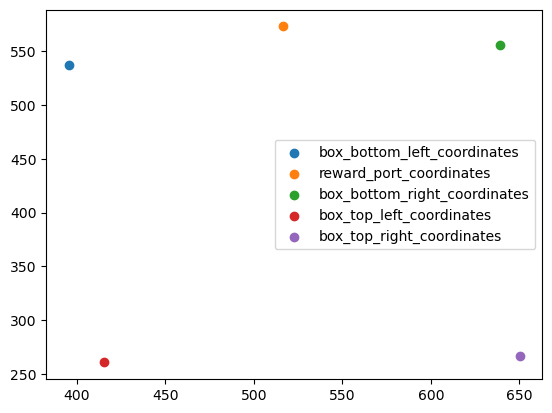

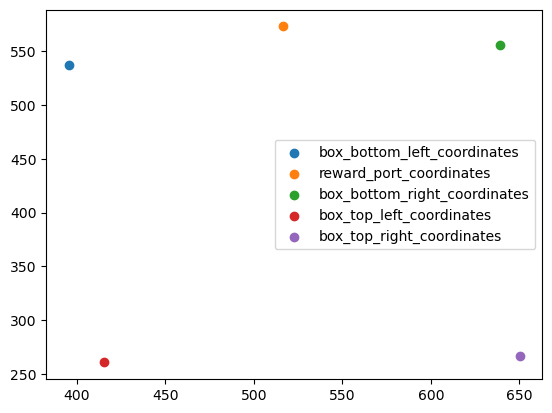

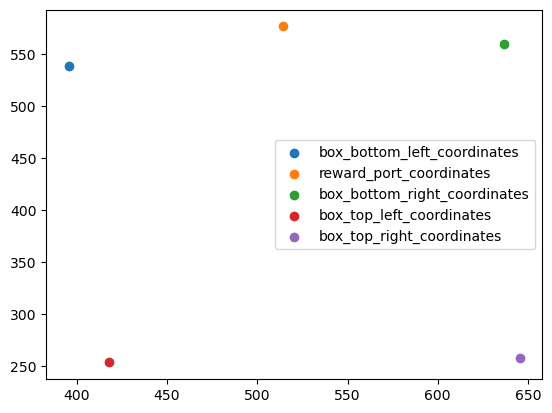

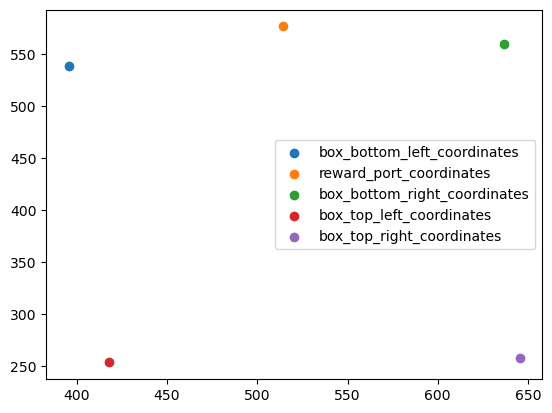

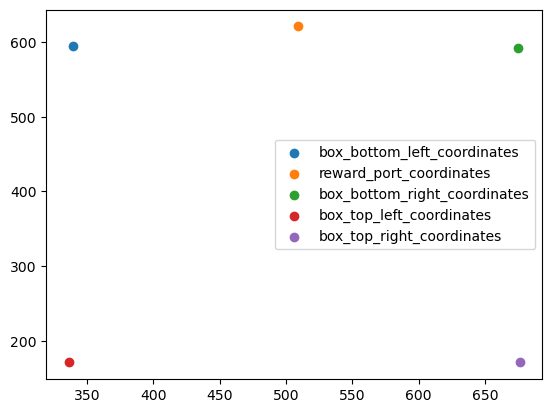

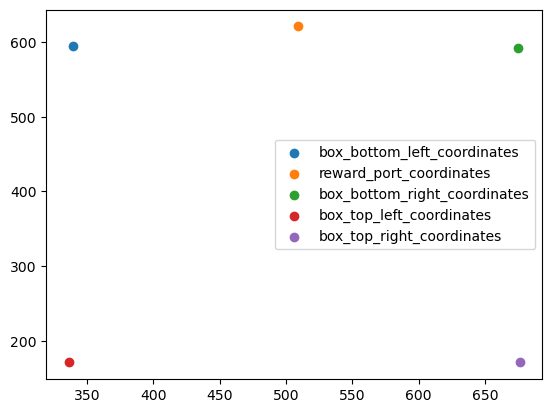

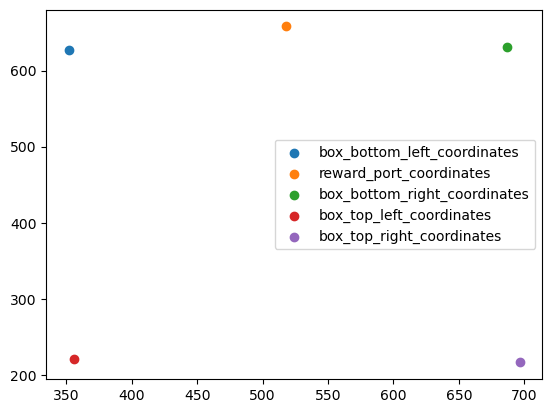

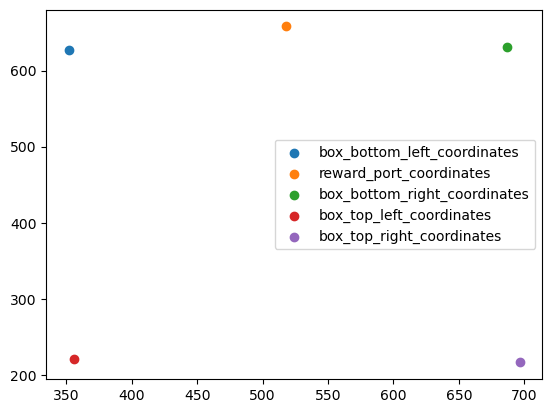

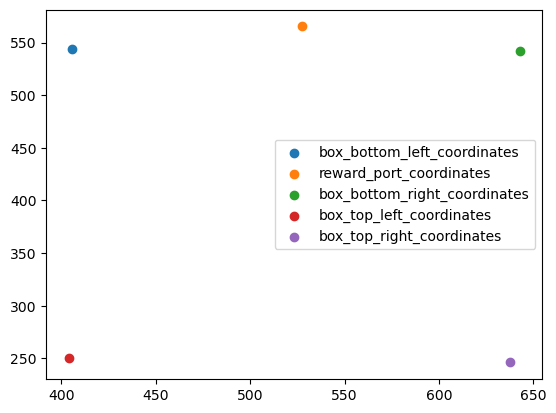

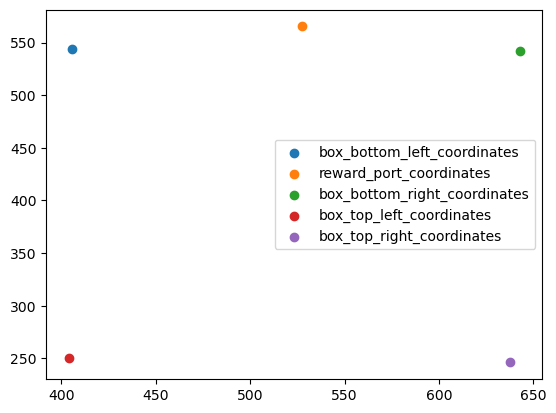

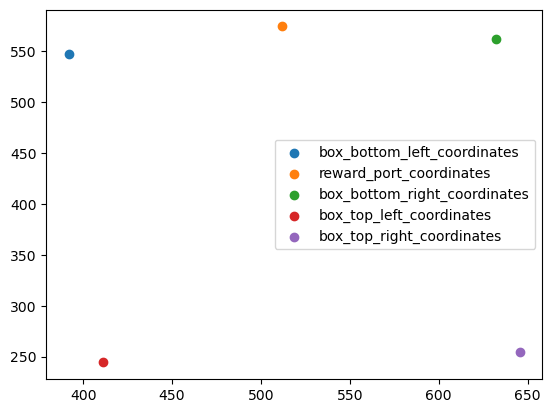

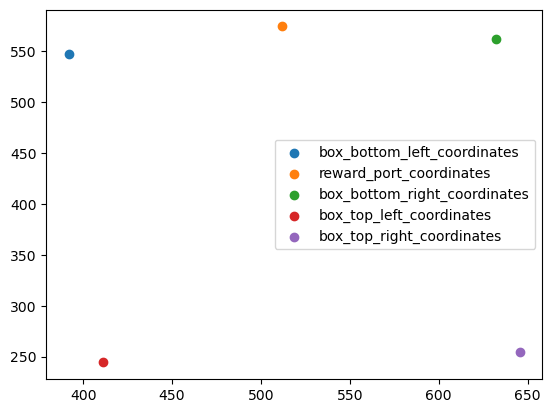

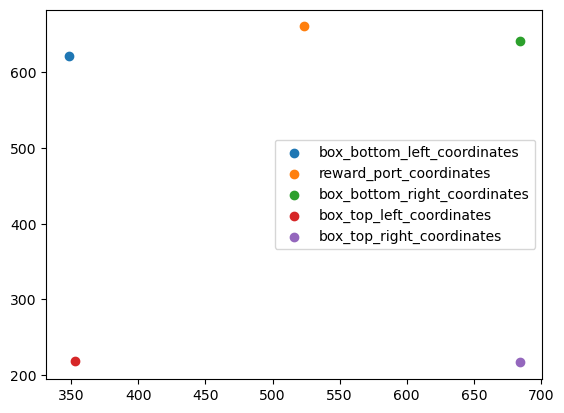

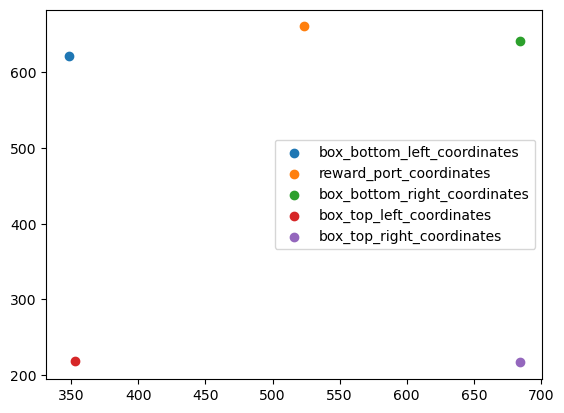

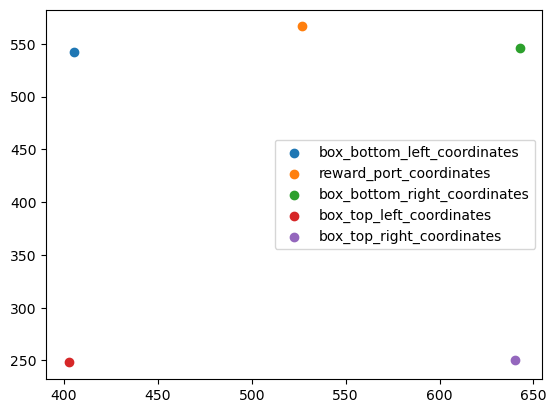

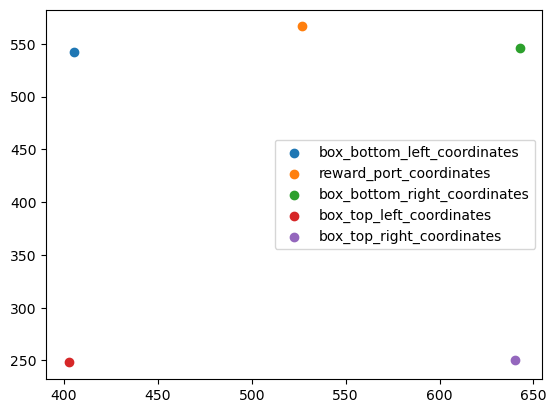

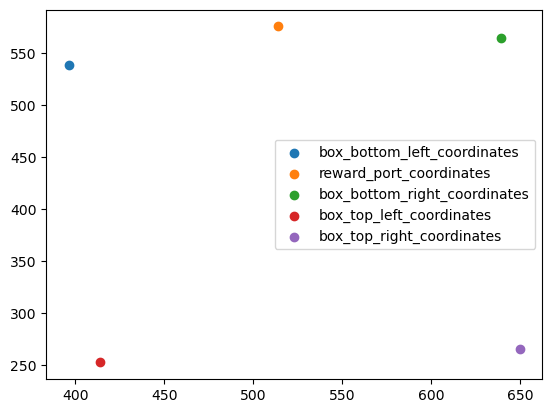

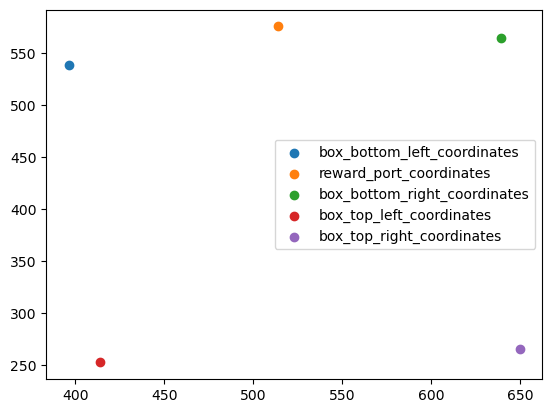

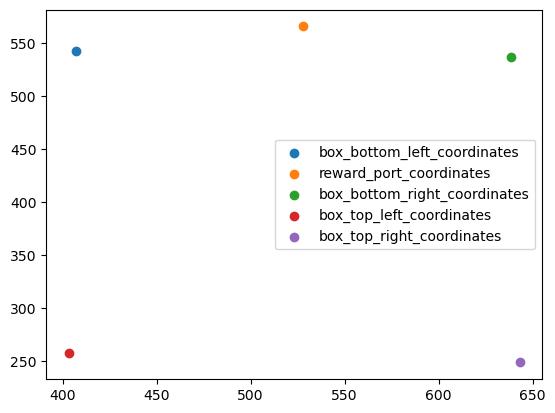

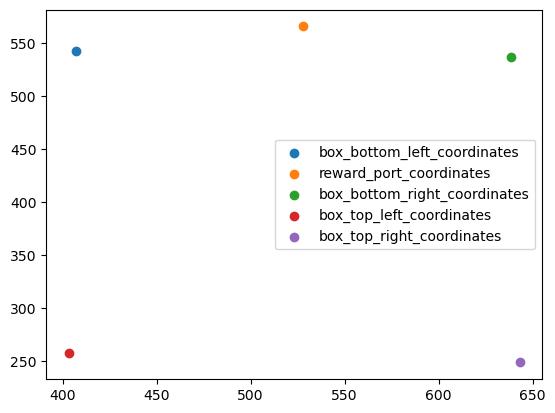

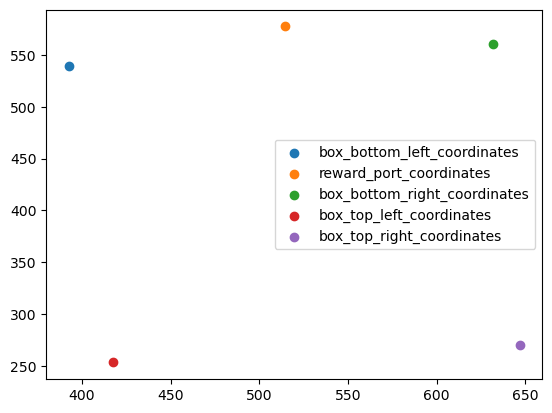

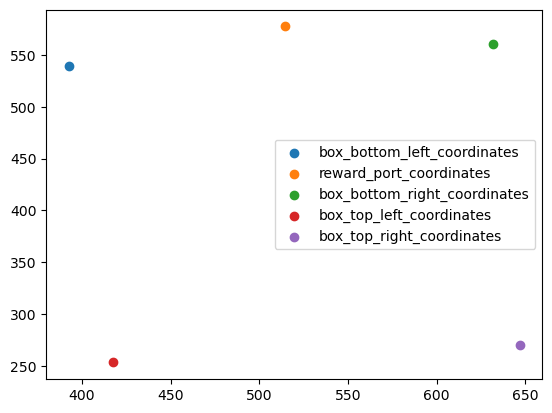

In [49]:
for index, row in TONE_START_DF.iterrows():
    fig, ax = plt.subplots()

    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    plt.legend()
    plt.show()
    plt.close()

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [50]:
TONE_START_DF["bottom_width"] = TONE_START_DF.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
TONE_START_DF["top_width"] = TONE_START_DF.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [51]:
TONE_START_DF["right_height"] = TONE_START_DF.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
TONE_START_DF["left_height"] = TONE_START_DF.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [52]:
TONE_START_DF["average_height"] = TONE_START_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
TONE_START_DF["average_width"] = TONE_START_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the cm per pixel value

In [53]:
TONE_START_DF["width_ratio"] = MEDPC_BOX_WIDTH / TONE_START_DF["average_width"]
TONE_START_DF["height_ratio"] = MEDPC_BOX_LENGTH / TONE_START_DF["average_height"]


- Scaling the reward port coordinates based on the ratios of the height and width to the actual cage

In [54]:
TONE_START_DF["reward_port_scaled"] = TONE_START_DF.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [55]:
TONE_START_DF["reward_port_scaled"][:5]

0      [62.65767561559346, 46.6450642268789]
0      [62.65767561559346, 46.6450642268789]
1    [44.79031206327622, 38.095121316373195]
1    [44.79031206327622, 38.095121316373195]
2     [44.42939704940567, 35.56550022490564]
Name: reward_port_scaled, dtype: object

# Getting the coordinates of each mouse

In [56]:
TONE_START_DF["pose_estimation_sleap"] = TONE_START_DF["pose_estimation_file"].apply(lambda x: extract_sleap_data_from_h5(x))

- Getting the track names of all the animals from SLEAP

In [57]:
TONE_START_DF["track_names"] = TONE_START_DF["pose_estimation_sleap"].apply(lambda x: x[2])

- Getting the ID of that track name from the track names list

In [58]:
TONE_START_DF["track_id"] = TONE_START_DF.apply(lambda x: x["track_names"].index(str(x["subj_id"]).strip()), axis=1)

In [59]:
TONE_START_DF["track_id"].head()

0    0
0    1
1    0
1    1
2    0
Name: track_id, dtype: int64

- Getting the track based on the ID

In [60]:
TONE_START_DF["subj_track"] = TONE_START_DF.apply(lambda x: x["pose_estimation_sleap"][0][:,:,:,x["track_id"]], axis=1)

- Interpolating missing coordinates

In [61]:
TONE_START_DF["pose_estimation_original_coordinates"] = TONE_START_DF.apply(lambda x: interpolate_missing_coords(x["subj_track"]), axis=1)


- Scaling coordinates

In [62]:
TONE_START_DF["pose_estimation_scaled_coordinates"] = TONE_START_DF.apply(lambda row: scale_sleap_coordinates(row, "pose_estimation_original_coordinates"), axis=1)     


- Getting the coordinates for specific body parts

In [63]:
TONE_START_DF["pose_estimation_sleap"].iloc[0][1]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [64]:
TONE_START_DF["pose_estimation_scaled_coordinates"].iloc[0].shape

(55952, 6, 2)

In [65]:
thorax_index = TONE_START_DF["pose_estimation_sleap"].iloc[0][1].index("thorax")

In [66]:
nose_index = TONE_START_DF["pose_estimation_sleap"].iloc[0][1].index("nose")

In [67]:
TONE_START_DF["pose_estimation_thorax_coordinates"] = TONE_START_DF["pose_estimation_scaled_coordinates"].apply(lambda x: x[:,thorax_index,:])
TONE_START_DF["pose_estimation_nose_coordinates"] = TONE_START_DF["pose_estimation_scaled_coordinates"].apply(lambda x: x[:,nose_index,:])



In [68]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,...,height_ratio,reward_port_scaled,pose_estimation_sleap,track_names,track_id,subj_track,pose_estimation_original_coordinates,pose_estimation_scaled_coordinates,pose_estimation_thorax_coordinates,pose_estimation_nose_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,0.081602,"[62.65767561559346, 46.6450642268789]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.1, 1.2]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...","[[61.95142736975598, 47.024957207474664], [61...."
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,0.081602,"[62.65767561559346, 46.6450642268789]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.1, 1.2]",1,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...","[[45.88192047944392, 22.883719500162446], [45...."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,0.057763,"[44.79031206327622, 38.095121316373195]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.3, 1.4]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...","[[56.56298560120289, 22.455181588334806], [56...."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,0.057763,"[44.79031206327622, 38.095121316373195]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[1.3, 1.4]",1,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...","[[44.43057909562303, 38.370441477231374], [44...."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",...,0.057216,"[44.42939704940567, 35.56550022490564]","([[[[nan nan]\n [nan nan]], [[nan nan]\n [nan ...","[2.1, 2.2]",0,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....","[[27.245267225786062, 27.659397618676238], [27..."


# Calculating the distance from thorax to reward port

In [69]:
TONE_START_DF["thorax_to_reward_port_distance"] = TONE_START_DF.apply(lambda row: np.linalg.norm(row["pose_estimation_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)
TONE_START_DF["nose_to_reward_port_distance"] = TONE_START_DF.apply(lambda row: np.linalg.norm(row["pose_estimation_nose_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [70]:
TONE_START_DF["thorax_to_reward_port_tone_slices"] = TONE_START_DF.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance"][tone_frame-FRAME_RANGE:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance"].shape[0]]), axis=1)
TONE_START_DF["nose_to_reward_port_tone_slices"] = TONE_START_DF.apply(lambda row:  np.vstack([row["nose_to_reward_port_distance"][tone_frame-FRAME_RANGE:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["nose_to_reward_port_distance"].shape[0]]), axis=1)



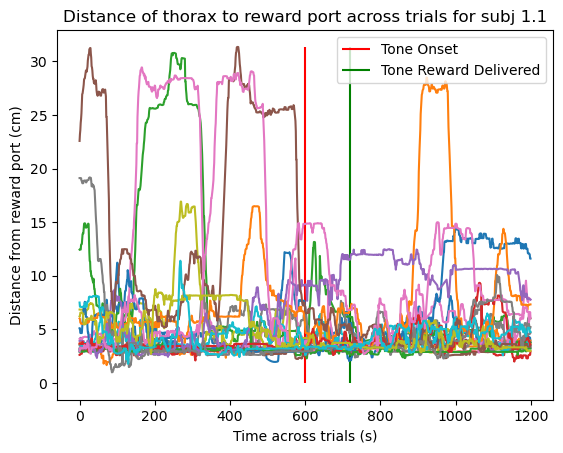

In [71]:
for index, row in TONE_START_DF.iterrows():
    fig, ax = plt.subplots()
    plt.xlabel("Time across trials (s)")
    plt.ylabel("Distance from reward port (cm)")
    plt.vlines(FRAME_RANGE, ymin=0, ymax=np.max(row["thorax_to_reward_port_tone_slices"]), label="Tone Onset", colors="r")
    plt.vlines(FRAME_RANGE + 4 * FRAME_RATE, ymin=0, ymax=np.max(row["thorax_to_reward_port_tone_slices"]), label="Tone Reward Delivered", colors="g")
    plt.title("Distance of thorax to reward port across trials for subj {}".format(row["subj_id"]))
    for i, row in enumerate(row["thorax_to_reward_port_tone_slices"]):
        # Plot the row data
        # sns.plot(row, label=f'Line {i+1}')
        sns.lineplot(row)
    plt.legend()
    plt.show()
    plt.close()
    break

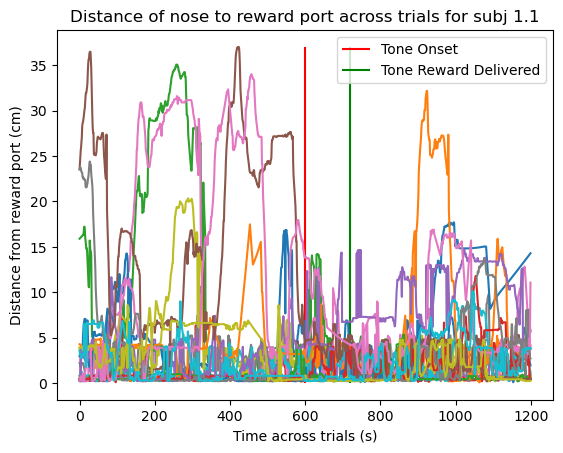

In [72]:
for index, row in TONE_START_DF.iterrows():
    fig, ax = plt.subplots()
    plt.xlabel("Time across trials (s)")
    plt.ylabel("Distance from reward port (cm)")
    plt.vlines(FRAME_RANGE, ymin=0, ymax=np.max(row["nose_to_reward_port_tone_slices"]), label="Tone Onset", colors="r")
    plt.vlines(FRAME_RANGE + 4 * FRAME_RATE, ymin=0, ymax=np.max(row["nose_to_reward_port_tone_slices"]), label="Tone Reward Delivered", colors="g")
    plt.title("Distance of nose to reward port across trials for subj {}".format(row["subj_id"]))
    for i, row in enumerate(row["nose_to_reward_port_tone_slices"]):
        # Plot the row data
        # sns.plot(row, label=f'Line {i+1}')
        sns.lineplot(row)
    plt.legend()
    plt.show()
    break

# Calculating the distance between agents

- Getting the distance by grouping rows that come from the same file
    - which would be all the subjects in a given recording

In [73]:
TONE_START_DF['distance_between_subject'] = TONE_START_DF.groupby(["file_base"], group_keys=False).apply(calculate_distance_between_subjects).reset_index(drop=True)

In [74]:
TONE_START_DF['distance_between_subject'].iloc[0][5]

26.40746303837872

## Calculating velocity

In [75]:
TONE_START_DF["all_thorax_velocity"] = TONE_START_DF["pose_estimation_thorax_coordinates"].apply(lambda x: compute_velocity(x, window_size=VELOCITY_WINDOW_SIZE) * FRAME_RATE)

In [76]:
# Rolling average to smooth it out
TONE_START_DF["all_thorax_velocity"] = TONE_START_DF["all_thorax_velocity"].apply(lambda x: rolling_average(x, window_size=ROLLING_AVERAGE_WINDOW_SIZE))

# Making a row for each trial

In [77]:
TONE_START_DF = TONE_START_DF.dropna(subset=["distance_between_subject"])

- Getting only the portion of the trial and before for different variables

In [78]:
# Column just for the trial number
TONE_START_DF["rc_trial_number"] = TONE_START_DF["thorax_to_reward_port_tone_slices"].apply(lambda x: list(range(1, x.shape[0]+1)))

In [79]:
TONE_START_DF["thorax_to_reward_port_baseline_slices"] = TONE_START_DF.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance"][tone_frame-FRAME_RANGE:tone_frame] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance"].shape[0]]), axis=1)

In [80]:
TONE_START_DF["thorax_to_reward_port_trial_slices"] = TONE_START_DF.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance"][tone_frame:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance"].shape[0]]), axis=1)

In [81]:
TONE_START_DF["scaled_coordinates_baseline_slices"] = TONE_START_DF.apply(lambda row: [row["pose_estimation_scaled_coordinates"][tone_frame-FRAME_RANGE:tone_frame] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

In [82]:
TONE_START_DF["scaled_coordinates_trial_slices"] = TONE_START_DF.apply(lambda row: [row["pose_estimation_scaled_coordinates"][tone_frame:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

In [83]:
TONE_START_DF["distance_between_subject_baseline_slices"] = TONE_START_DF.apply(lambda row: [row["distance_between_subject"][tone_frame-FRAME_RANGE:tone_frame] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

In [84]:
TONE_START_DF["distance_between_subject_trial_slices"] = TONE_START_DF.apply(lambda row: [row["distance_between_subject"][tone_frame:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

In [85]:
TONE_START_DF["thorax_velocity_baseline_slices"] = TONE_START_DF.apply(lambda row: [row["all_thorax_velocity"][tone_frame-FRAME_RANGE:tone_frame] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

In [86]:
TONE_START_DF["thorax_velocity_trial_slices"] = TONE_START_DF.apply(lambda row: [row["all_thorax_velocity"][tone_frame:tone_frame+FRAME_RANGE] for tone_frame in row["all_tone_frame"] if tone_frame <= row["pose_estimation_original_coordinates"].shape[0]], axis=1)

- Creating a row for each trial

In [87]:
EXPLODED_TONE_START_DF = TONE_START_DF.explode(['rc_trial_number', 'thorax_to_reward_port_trial_slices', 'thorax_to_reward_port_baseline_slices', 'scaled_coordinates_trial_slices', 'scaled_coordinates_baseline_slices', 'distance_between_subject_baseline_slices', 'distance_between_subject_trial_slices', 'thorax_velocity_baseline_slices', 'thorax_velocity_trial_slices'])

In [88]:
EXPLODED_TONE_START_DF.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'file_base', 'date',
       'all_subj', 'subj_id', 'subj_index', 'all_tone_frame', 'corner_file',
       'pose_estimation_file', 'corner_sleap', 'box_bottom_left_coordinates',
       'reward_port_coordinates', 'box_bottom_right_coordinates',
       'box_top_left_coordinates', 'box_top_right_coordinates', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'reward_port_scaled',
       'pose_estimation_sleap', 'track_names', 'track_id', 'subj_track',
       'pose_estimation_original_coordinates',
       'pose_estimation_scaled_coordinates',
       'pose_estimation_thorax_coordinates',
       'pose_estimation_nose_coordinates', 'thorax_to_reward_port_distance',
       'nose_to_reward_port_distance', 'thorax_to_reward_port_tone_slices',
       'nose_to_reward_port_tone_slices', 'distance_between_subject',
       'all_thorax_velocity', 'rc_trial_number'

In [89]:
# Dropping columns that have data from outside the trials
EXPLODED_TONE_START_DF = EXPLODED_TONE_START_DF.drop(columns=["pose_estimation_original_coordinates", "pose_estimation_sleap", 'all_thorax_velocity', 'pose_estimation_scaled_coordinates', 'pose_estimation_thorax_coordinates', 'pose_estimation_nose_coordinates', 'thorax_to_reward_port_tone_slices', 'distance_between_subject', 'subj_track', 'thorax_to_reward_port_distance', 'nose_to_reward_port_distance', 'nose_to_reward_port_tone_slices'], errors="ignore")

In [90]:
# Removing trials that were not actually trials but still part of the video
EXPLODED_TONE_START_DF = EXPLODED_TONE_START_DF[EXPLODED_TONE_START_DF["rc_trial_number"] <= ALL_TRIAL_NUMBERS]

In [91]:
EXPLODED_TONE_START_DF.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'file_base', 'date',
       'all_subj', 'subj_id', 'subj_index', 'all_tone_frame', 'corner_file',
       'pose_estimation_file', 'corner_sleap', 'box_bottom_left_coordinates',
       'reward_port_coordinates', 'box_bottom_right_coordinates',
       'box_top_left_coordinates', 'box_top_right_coordinates', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'reward_port_scaled',
       'track_names', 'track_id', 'rc_trial_number',
       'thorax_to_reward_port_baseline_slices',
       'thorax_to_reward_port_trial_slices',
       'scaled_coordinates_baseline_slices', 'scaled_coordinates_trial_slices',
       'distance_between_subject_baseline_slices',
       'distance_between_subject_trial_slices',
       'thorax_velocity_baseline_slices', 'thorax_velocity_trial_slices'],
      dtype='object')

In [92]:
EXPLODED_TONE_START_DF.to_pickle("./per_trial_rc_distance.pkl")

In [93]:
EXPLODED_TONE_START_DF["File Name"]

0            10-03-22_Test_1_1-1v1-2
0            10-03-22_Test_1_1-1v1-2
0            10-03-22_Test_1_1-1v1-2
0            10-03-22_Test_1_1-1v1-2
0            10-03-22_Test_1_1-1v1-2
                   ...              
32    10-04-22_Test_16_6-2v6-4.fixed
32    10-04-22_Test_16_6-2v6-4.fixed
32    10-04-22_Test_16_6-2v6-4.fixed
32    10-04-22_Test_16_6-2v6-4.fixed
32    10-04-22_Test_16_6-2v6-4.fixed
Name: File Name, Length: 1174, dtype: object

In [94]:
EXPLODED_TONE_START_DF["all_tone_frame"].iloc[-1][19]

54372

# Averaging across trials based on strain

In [95]:
TONE_START_DF["n_trials"] = TONE_START_DF["thorax_to_reward_port_tone_slices"].apply(lambda x: x.shape[0])

In [96]:
TONE_START_DF["thorax_to_reward_port_tone_trial_average"] = TONE_START_DF["thorax_to_reward_port_tone_slices"].apply(lambda x: np.nanmean(x, axis=0))
TONE_START_DF["nose_to_reward_port_tone_trial_average"] = TONE_START_DF["nose_to_reward_port_tone_slices"].apply(lambda x: np.nanmean(x, axis=0))


In [97]:
TONE_START_DF["thorax_to_reward_port_tone_slices"].iloc[0]

array([[ 2.9228068 ,  2.9940085 ,  2.99664937, ...,  4.21771925,
         4.21769666,  3.78387435],
       [ 3.62913037,  3.62735926,  3.64067937, ...,  3.93809556,
         3.93707695,  3.94414308],
       [12.43298243, 12.46119208, 12.45729386, ...,  3.73184645,
         3.7432129 ,  3.76634885],
       ...,
       [19.10854561, 19.11093297, 19.11013853, ...,  4.55801088,
         4.70161616,  4.69727818],
       [ 6.22053037,  6.19778137,  6.55475818, ...,  2.98069287,
         2.99566431,  2.98952016],
       [ 7.49787603,  7.11390129,  7.10140241, ...,  4.76586926,
         4.7577642 ,  4.7613551 ]])

In [98]:
c57_df = TONE_START_DF[TONE_START_DF["Strain"] == "C57"].copy()
cd1_df = TONE_START_DF[TONE_START_DF["Strain"] == "CD1"].copy()

In [99]:
# Stack the 2D arrays
c57_thorax_trials = np.vstack(c57_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_thorax_mean_distance = c57_thorax_trials.mean(axis=0)
c57_thorax_sem_distance = c57_thorax_trials.std(axis=0) / np.sqrt(c57_thorax_trials.shape[0])

In [100]:
# Stack the 2D arrays
cd1_thorax_trials = np.vstack(cd1_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_thorax_mean_distance = cd1_thorax_trials.mean(axis=0)
cd1_thorax_sem_distance = cd1_thorax_trials.std(axis=0) / np.sqrt(cd1_thorax_trials.shape[0])

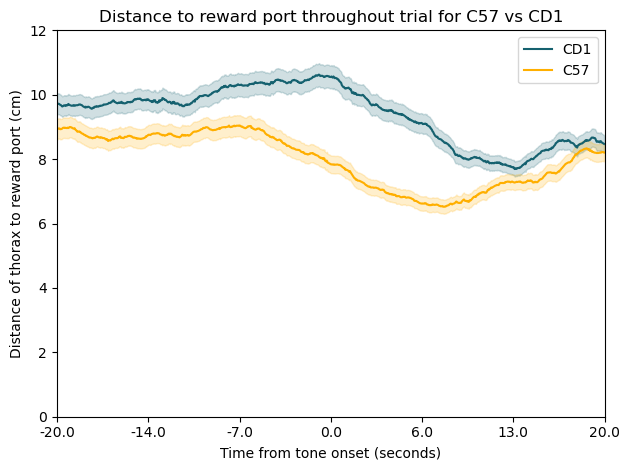

In [101]:
# Add shading for the standard error
sns.lineplot(cd1_thorax_mean_distance, color="#15616f", label="CD1")
plt.fill_between(range(len(cd1_thorax_mean_distance)), cd1_thorax_mean_distance - cd1_thorax_sem_distance, cd1_thorax_mean_distance + cd1_thorax_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_thorax_mean_distance, color="#ffaf00", label="C57")

plt.fill_between(range(len(c57_thorax_mean_distance)), c57_thorax_mean_distance - c57_thorax_sem_distance, c57_thorax_mean_distance + c57_thorax_sem_distance, color="#ffaf00", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("Distance to reward port throughout trial for C57 vs CD1")
plt.tight_layout()
plt.legend()
plt.savefig("./proc/rc_thorax_distance_strain.png")

In [102]:
# Stack the 2D arrays
c57_nose_trials = np.vstack(c57_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_nose_mean_distance = c57_nose_trials.mean(axis=0)
c57_nose_sem_distance = c57_nose_trials.std(axis=0) / np.sqrt(c57_nose_trials.shape[0])

In [103]:
# Stack the 2D arrays
cd1_nose_trials = np.vstack(cd1_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_nose_mean_distance = cd1_nose_trials.mean(axis=0)
cd1_nose_sem_distance = cd1_nose_trials.std(axis=0) / np.sqrt(cd1_nose_trials.shape[0])

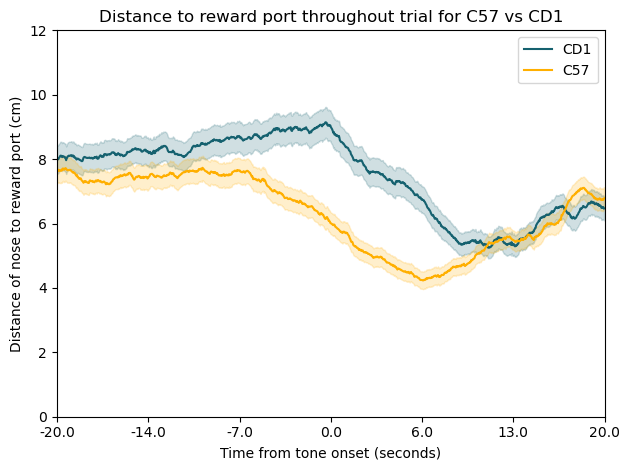

In [104]:
# Add shading for the standard error
sns.lineplot(cd1_nose_mean_distance, color="#15616f", label="CD1")
plt.fill_between(range(len(cd1_nose_mean_distance)), cd1_nose_mean_distance - cd1_nose_sem_distance, cd1_nose_mean_distance + cd1_nose_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_nose_mean_distance, color="#ffaf00", label="C57")

plt.fill_between(range(len(c57_nose_mean_distance)), c57_nose_mean_distance - c57_nose_sem_distance, c57_nose_mean_distance + c57_nose_sem_distance, color="#ffaf00", alpha=0.2)
plt.ylabel("Distance of nose to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("Distance to reward port throughout trial for C57 vs CD1")
plt.tight_layout()
plt.legend()
plt.savefig("./proc/rc_nose_distance_strain.png")

# Adding the win and loss information

## Combining the distance and scoring dataframes

- Updating the date so that we can merge using it

In [105]:
REWARD_COMP_SCORING_DF["date"] = REWARD_COMP_SCORING_DF["rc_date"].apply(lambda x: str(x).strip(""))

In [106]:
REWARD_COMP_SCORING_DF["date"].iloc[0]

'2022-10-03'

- Updating the IDs so we can merge using it

In [107]:
REWARD_COMP_SCORING_DF["all_subj"] = REWARD_COMP_SCORING_DF["rc_tuple_animal_id"].apply(lambda x: ast.literal_eval(x))

In [108]:
REWARD_COMP_SCORING_DF["all_subj"].iloc[0]

('1.1', '1.2')

In [109]:
REWARD_COMP_SCORING_DF["rc_winner"] = REWARD_COMP_SCORING_DF["rc_winner"].apply(lambda x: ast.literal_eval(x))

In [110]:
REWARD_COMP_SCORING_DF["rc_averaged_winner"] = REWARD_COMP_SCORING_DF["rc_averaged_winner"].astype(str)
REWARD_COMP_SCORING_DF["rc_averaged_loser"] = REWARD_COMP_SCORING_DF["rc_averaged_loser"].astype(str)

In [111]:
for num in REWARD_COMP_SCORING_DF["rc_winner"][:5]:
    print(num)

['1.1', '1.2', '1.2', '1.1', 'tie', '1.1', '1.1', 'tie', '1.1', '1.2', 'tie', '1.2', '1.1', 'tie', '1.2', '1.2', '1.2', '1.2', '1.2']
['1.1', '1.1', '1.1', '1.1', '1.1', 'tie', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
['1.3', '1.3', '1.3', '1.3', '1.1', '1.1', 'tie', '1.1', '1.3', '1.1', 'tie', '1.1', 'tie', '1.3', '1.3', '1.3', '1.3', 'tie', 'tie']
['1.3', '1.3', 'tie', '1.3', '1.3', '1.3', '1.3', '1.1', 'tie', 'tie', '1.1', '1.3', '1.1', '1.1', '1.3', '1.1', '1.1', 'tie', '1.3']
['1.4', '1.4', '1.4', '1.4', '1.4', '1.4', '1.4', '1.1', '1.1', '1.4', '1.4', '1.1', '1.4', 'tie', '1.4', '1.1', '1.1', '1.4', '1.1']


- Merging the dataframes

In [112]:
REWARD_COMP_SCORING_DF["date"].head()

0    2022-10-03
1    2022-10-04
2    2022-10-03
3    2022-10-04
4    2022-10-03
Name: date, dtype: object

In [113]:
TONE_START_DF["date"].head()

0    2022-10-03
0    2022-10-03
1    2022-10-03
1    2022-10-03
2    2022-10-03
Name: date, dtype: object

In [114]:
REWARD_COMP_SCORING_DF["all_subj"].head()

0    (1.1, 1.2)
1    (1.1, 1.2)
2    (1.1, 1.3)
3    (1.1, 1.3)
4    (1.1, 1.4)
Name: all_subj, dtype: object

In [115]:
TONE_START_DF["all_subj"].head()

0    (1.1, 1.2)
0    (1.1, 1.2)
1    (1.3, 1.4)
1    (1.3, 1.4)
2    (2.1, 2.2)
Name: all_subj, dtype: object

In [116]:
distance_and_scoring_df = TONE_START_DF.merge(REWARD_COMP_SCORING_DF, on=['date', 'all_subj'], how='outer')

In [117]:
distance_and_scoring_df = distance_and_scoring_df.dropna(subset=["rc_winner", "subj_id"])

In [118]:
distance_and_scoring_df.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,...,rc_averaged_loser,rc_averaged_winner_win_count,rc_averaged_loser_win_count,rc_tie_count,rc_all_match_count_including_ties,rc_averaged_winner_win_count_minus_loser_win_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
0,10-03-22_Test_1_1-1v1-2,2135.0,30.0,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0.0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,1.1,9,6,4,19,3,0.600000,0.473684,False,0.210526
1,10-03-22_Test_1_1-1v1-2,2135.0,30.0,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1.0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",...,1.1,9,6,4,19,3,0.600000,0.473684,False,0.210526
2,10-03-22_Test_2_1-3v1-4,2123.0,29.0,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0.0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,1.4,8,8,3,19,0,0.500000,0.421053,True,0.157895
3,10-03-22_Test_2_1-3v1-4,2123.0,29.0,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1.0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",...,1.4,8,8,3,19,0,0.500000,0.421053,True,0.157895
4,10-03-22_Test_3_2-1v2-2,2125.0,29.0,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0.0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",...,2.2,13,5,1,19,8,0.722222,0.684211,False,0.052632


## Adding the win or loss outcome for each trial based on the subject 

In [119]:
distance_and_scoring_df["subj_id"].unique()

array(['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '2.4', '2.3', '3.2',
       '3.4', '3.1', '3.3', '4.1', '4.2', '4.3', '4.4', '6.1', '6.2',
       '6.3', '6.4', '5.2', '5.4', '5.1', '5.3'], dtype=object)

- Getting the id of the agent

In [120]:
distance_and_scoring_df["agent_id"] = distance_and_scoring_df.apply(lambda x: list(set(x["all_subj"]) - set([x["subj_id"]]))[0], axis=1)

In [121]:
distance_and_scoring_df["agent_id"].head()

0    1.2
1    1.1
2    1.4
3    1.3
4    2.2
Name: agent_id, dtype: object

- Getting all the winning and losing trials based on matching IDs

In [122]:
distance_and_scoring_df["trial_outcome"] = distance_and_scoring_df.apply(lambda x: ["win" if winner == x["subj_id"] else "loss" if winner == x["agent_id"] else "tie" for winner in x["rc_winner"]], axis=1) 


In [123]:
distance_and_scoring_df["trial_outcome"].head(n=10)

0    [win, loss, loss, win, tie, win, win, tie, win...
1    [loss, win, win, loss, tie, loss, loss, tie, l...
2    [win, loss, win, loss, loss, win, loss, win, t...
3    [loss, win, loss, win, win, loss, win, loss, t...
4    [loss, win, win, win, win, win, win, tie, win,...
5    [win, loss, loss, loss, loss, loss, loss, tie,...
6    [loss, loss, win, win, win, win, win, loss, wi...
7    [win, win, loss, loss, loss, loss, loss, win, ...
8    [win, win, win, loss, win, win, win, loss, los...
9    [loss, loss, loss, win, loss, loss, loss, win,...
Name: trial_outcome, dtype: object

In [124]:
distance_and_scoring_df["per_trial_winning_indexes"] = distance_and_scoring_df["trial_outcome"].apply(lambda x: [i for i, outcome in enumerate(x) if outcome == "win"])
distance_and_scoring_df["per_trial_losing_indexes"] = distance_and_scoring_df["trial_outcome"].apply(lambda x: [i for i, outcome in enumerate(x) if outcome == "loss"])


In [125]:
distance_and_scoring_df["per_trial_winning_indexes"].head()

0                             [0, 3, 5, 6, 8, 12]
1               [1, 2, 9, 11, 14, 15, 16, 17, 18]
2                     [0, 2, 5, 7, 9, 12, 15, 16]
3                    [1, 3, 4, 6, 10, 11, 14, 17]
4    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 16, 17]
Name: per_trial_winning_indexes, dtype: object

In [126]:
distance_and_scoring_df["per_trial_losing_indexes"].head()

0    [1, 2, 9, 11, 14, 15, 16, 17, 18]
1                  [0, 3, 5, 6, 8, 12]
2         [1, 3, 4, 6, 10, 11, 14, 17]
3          [0, 2, 5, 7, 9, 12, 15, 16]
4                  [0, 12, 13, 15, 18]
Name: per_trial_losing_indexes, dtype: object

In [127]:
distance_and_scoring_df["thorax_to_reward_port_tone_slices"].iloc[0].shape

(20, 1200)

In [128]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"] = distance_and_scoring_df.apply(lambda x: get_filtered_trials(x, "per_trial_winning_indexes", "thorax_to_reward_port_tone_slices"), axis=1)
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"] = distance_and_scoring_df.apply(lambda x: get_filtered_trials(x, "per_trial_losing_indexes", "thorax_to_reward_port_tone_slices"), axis=1)

In [129]:
distance_and_scoring_df["nose_to_reward_port_all_winning_trial_distances"] = distance_and_scoring_df.apply(lambda x: get_filtered_trials(x, "per_trial_winning_indexes", "nose_to_reward_port_tone_slices"), axis=1)
distance_and_scoring_df["nose_to_reward_port_all_losing_trial_distances"] = distance_and_scoring_df.apply(lambda x: get_filtered_trials(x, "per_trial_losing_indexes", "nose_to_reward_port_tone_slices"), axis=1)

In [130]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[0].shape

(6, 1200)

In [131]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[0].shape

(9, 1200)

- Averaging across winning and losing trials

In [132]:
c57_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "C57"].copy()
cd1_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "CD1"].copy()

In [133]:
body_parts = ["nose", "thorax"]
outcomes = ["winning", "losing"]

In [134]:

c57_outcome_based_trials = {}
for part in body_parts:
    c57_outcome_based_trials[part] = {}
    for outcome in outcomes:
        trials_key = f'{part}_to_reward_port_all_{outcome}_trial_distances'
        trials = np.vstack(c57_distance_and_scoring_df[trials_key].to_list())
        
        mean_distance = trials.mean(axis=0)
        sem_distance = trials.std(axis=0) / np.sqrt(trials.shape[0])
        
        c57_outcome_based_trials[part][outcome] = {
            'mean': mean_distance,
            'sem': sem_distance
        }

In [135]:
cd1_outcome_based_trials = {}
for part in body_parts:
    cd1_outcome_based_trials[part] = {}
    for outcome in outcomes:
        trials_key = f'{part}_to_reward_port_all_{outcome}_trial_distances'
        trials = np.vstack(cd1_distance_and_scoring_df[trials_key].to_list())
        
        mean_distance = trials.mean(axis=0)
        sem_distance = trials.std(axis=0) / np.sqrt(trials.shape[0])
        
        cd1_outcome_based_trials[part][outcome] = {
            'mean': mean_distance,
            'sem': sem_distance
        }

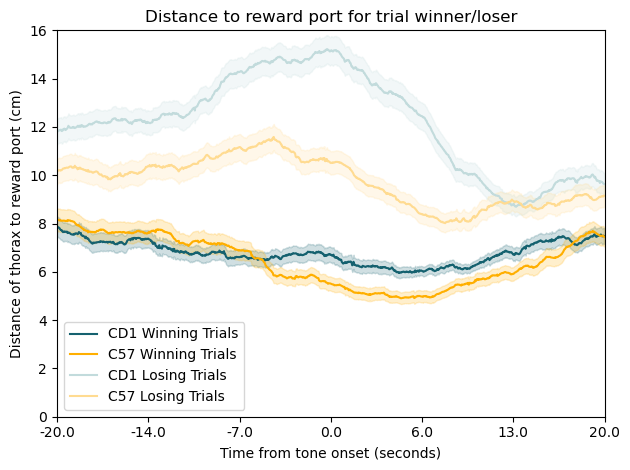

In [136]:
# Add shading for the standard error
sns.lineplot(cd1_outcome_based_trials["thorax"]["winning"]["mean"], color="#15616f", label="CD1 Winning Trials")
plt.fill_between(range(len(cd1_outcome_based_trials["thorax"]["winning"]["mean"])), cd1_outcome_based_trials["thorax"]["winning"]["mean"] - cd1_outcome_based_trials["thorax"]["winning"]["sem"], cd1_outcome_based_trials["thorax"]["winning"]["mean"] + cd1_outcome_based_trials["thorax"]["winning"]["sem"], color="#15616f", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_outcome_based_trials["thorax"]["winning"]["mean"], color="#ffaf00", label="C57 Winning Trials")
plt.fill_between(range(len(c57_outcome_based_trials["thorax"]["winning"]["mean"])), c57_outcome_based_trials["thorax"]["winning"]["mean"] - c57_outcome_based_trials["thorax"]["winning"]["sem"], c57_outcome_based_trials["thorax"]["winning"]["mean"] + c57_outcome_based_trials["thorax"]["winning"]["sem"], color="#ffaf00", alpha=0.2)

# Add shading for the standard error
sns.lineplot(cd1_outcome_based_trials["thorax"]["losing"]["mean"], color="#C2DBDC", label="CD1 Losing Trials")
plt.fill_between(range(len(cd1_outcome_based_trials["thorax"]["losing"]["mean"])), cd1_outcome_based_trials["thorax"]["losing"]["mean"] - cd1_outcome_based_trials["thorax"]["losing"]["sem"], cd1_outcome_based_trials["thorax"]["losing"]["mean"] + cd1_outcome_based_trials["thorax"]["losing"]["sem"], color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_outcome_based_trials["thorax"]["losing"]["mean"], color="#FFDB91", label="C57 Losing Trials")
plt.fill_between(range(len(c57_outcome_based_trials["thorax"]["losing"]["mean"])), c57_outcome_based_trials["thorax"]["losing"]["mean"] - c57_outcome_based_trials["thorax"]["losing"]["sem"], c57_outcome_based_trials["thorax"]["losing"]["mean"] + c57_outcome_based_trials["thorax"]["losing"]["sem"], color="#FFDB91", alpha=0.2)

plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 16)

plt.title("Distance to reward port for trial winner/loser")
plt.tight_layout()
plt.legend()
plt.savefig("./proc/rc_thorax_trial_winner_distance.png")

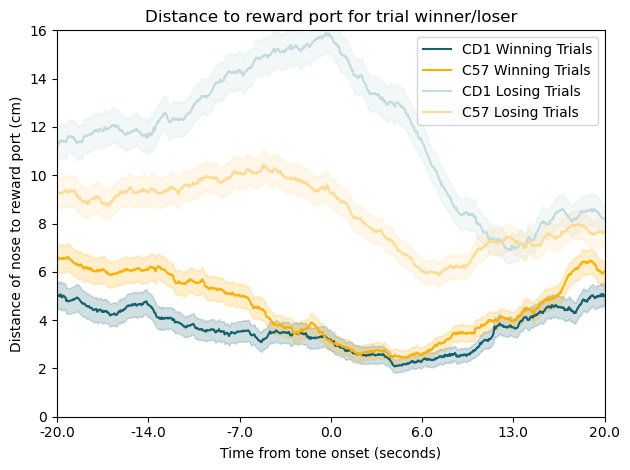

In [137]:
# Add shading for the standard error
sns.lineplot(cd1_outcome_based_trials["nose"]["winning"]["mean"], color="#15616f", label="CD1 Winning Trials")
plt.fill_between(range(len(cd1_outcome_based_trials["nose"]["winning"]["mean"])), cd1_outcome_based_trials["nose"]["winning"]["mean"] - cd1_outcome_based_trials["nose"]["winning"]["sem"], cd1_outcome_based_trials["nose"]["winning"]["mean"] + cd1_outcome_based_trials["nose"]["winning"]["sem"], color="#15616f", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_outcome_based_trials["nose"]["winning"]["mean"], color="#ffaf00", label="C57 Winning Trials")
plt.fill_between(range(len(c57_outcome_based_trials["nose"]["winning"]["mean"])), c57_outcome_based_trials["nose"]["winning"]["mean"] - c57_outcome_based_trials["nose"]["winning"]["sem"], c57_outcome_based_trials["nose"]["winning"]["mean"] + c57_outcome_based_trials["nose"]["winning"]["sem"], color="#ffaf00", alpha=0.2)

# Add shading for the standard error
sns.lineplot(cd1_outcome_based_trials["nose"]["losing"]["mean"], color="#C2DBDC", label="CD1 Losing Trials")
plt.fill_between(range(len(cd1_outcome_based_trials["nose"]["losing"]["mean"])), cd1_outcome_based_trials["nose"]["losing"]["mean"] - cd1_outcome_based_trials["nose"]["losing"]["sem"], cd1_outcome_based_trials["nose"]["losing"]["mean"] + cd1_outcome_based_trials["nose"]["losing"]["sem"], color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
sns.lineplot(c57_outcome_based_trials["nose"]["losing"]["mean"], color="#FFDB91", label="C57 Losing Trials")
plt.fill_between(range(len(c57_outcome_based_trials["nose"]["losing"]["mean"])), c57_outcome_based_trials["nose"]["losing"]["mean"] - c57_outcome_based_trials["nose"]["losing"]["sem"], c57_outcome_based_trials["nose"]["losing"]["mean"] + c57_outcome_based_trials["nose"]["losing"]["sem"], color="#FFDB91", alpha=0.2)

plt.ylabel("Distance of nose to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 16)

plt.title("Distance to reward port for trial winner/loser")
plt.tight_layout()
plt.legend()
plt.savefig("./proc/rc_nose_trial_winner_distance.png")

# Seeing what the difference between distances are for winner/loser per trial

In [138]:
# TODO

In [139]:
distance_and_scoring_df.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'file_base', 'date',
       'all_subj', 'subj_id', 'subj_index', 'all_tone_frame', 'corner_file',
       'pose_estimation_file', 'corner_sleap', 'box_bottom_left_coordinates',
       'reward_port_coordinates', 'box_bottom_right_coordinates',
       'box_top_left_coordinates', 'box_top_right_coordinates', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'reward_port_scaled',
       'pose_estimation_sleap', 'track_names', 'track_id', 'subj_track',
       'pose_estimation_original_coordinates',
       'pose_estimation_scaled_coordinates',
       'pose_estimation_thorax_coordinates',
       'pose_estimation_nose_coordinates', 'thorax_to_reward_port_distance',
       'nose_to_reward_port_distance', 'thorax_to_reward_port_tone_slices',
       'nose_to_reward_port_tone_slices', 'distance_between_subject',
       'all_thorax_velocity', 'rc_trial_number'

In [140]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[0]

array([[2.9228068 , 2.9940085 , 2.99664937, ..., 4.21771925, 4.21769666,
        3.78387435],
       [2.61475148, 2.61980546, 2.69238637, ..., 2.61648381, 2.61631345,
        2.92201846],
       [3.20593772, 3.20892233, 3.20898215, ..., 6.04333462, 6.00650068,
        6.0168895 ],
       [4.10348043, 4.11425535, 4.12641752, ..., 7.83780359, 7.82222916,
        7.7792594 ],
       [6.8455238 , 6.83401129, 6.83059416, ..., 3.62872228, 3.63094884,
        3.62311631],
       [2.93300064, 2.92621516, 2.92192196, ..., 3.20292979, 3.20032924,
        3.19949613]])

# Separating by overall winner and loser

- TODO: Ask if we should include ties or not

In [141]:
no_tie_distance_and_scoring_df = distance_and_scoring_df[~distance_and_scoring_df["rc_is_win_to_win_and_loss_ratio_tie"]]

In [142]:
no_tie_distance_and_scoring_df["is_winner"] = no_tie_distance_and_scoring_df["subj_id"] == no_tie_distance_and_scoring_df["rc_averaged_winner"]

In [143]:
no_tie_distance_and_scoring_df["is_winner"].head(n=10)

0     False
1      True
4      True
5     False
8      True
9     False
10     True
11    False
12    False
13     True
Name: is_winner, dtype: bool

In [144]:
c57_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & (no_tie_distance_and_scoring_df["is_winner"])]
c57_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & ~(no_tie_distance_and_scoring_df["is_winner"])]

cd1_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & (no_tie_distance_and_scoring_df["is_winner"])]
cd1_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & ~(no_tie_distance_and_scoring_df["is_winner"])]

- Overall winner for thorax

In [145]:
# Stack the 2D arrays
c57_overall_winner_thorax_trials = np.vstack(c57_winner_distance_and_scoring_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_overall_winner_thorax_mean_distance = c57_overall_winner_thorax_trials.mean(axis=0)
c57_overall_winner_thorax_sem_distance = c57_overall_winner_thorax_trials.std(axis=0) / np.sqrt(c57_overall_winner_thorax_trials.shape[0])

In [146]:
# Stack the 2D arrays
cd1_overall_winner_thorax_trials = np.vstack(cd1_winner_distance_and_scoring_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_overall_winner_thorax_mean_distance = cd1_overall_winner_thorax_trials.mean(axis=0)
cd1_overall_winner_thorax_sem_distance = cd1_overall_winner_thorax_trials.std(axis=0) / np.sqrt(cd1_overall_winner_thorax_trials.shape[0])

- Overall loser for thorax

In [147]:
# Stack the 2D arrays
c57_overall_loser_thorax_trials = np.vstack(c57_loser_distance_and_scoring_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_overall_loser_thorax_mean_distance = c57_overall_loser_thorax_trials.mean(axis=0)
c57_overall_loser_thorax_sem_distance = c57_overall_loser_thorax_trials.std(axis=0) / np.sqrt(c57_overall_loser_thorax_trials.shape[0])

In [148]:
# Stack the 2D arrays
cd1_overall_loser_thorax_trials = np.vstack(cd1_loser_distance_and_scoring_df['thorax_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_overall_loser_thorax_mean_distance = cd1_overall_loser_thorax_trials.mean(axis=0)
cd1_overall_loser_thorax_sem_distance = cd1_overall_loser_thorax_trials.std(axis=0) / np.sqrt(cd1_overall_loser_thorax_trials.shape[0])

- Overall winner for nose

In [149]:
# Stack the 2D arrays
c57_overall_winner_nose_trials = np.vstack(c57_winner_distance_and_scoring_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_overall_winner_nose_mean_distance = c57_overall_winner_nose_trials.mean(axis=0)
c57_overall_winner_nose_sem_distance = c57_overall_winner_nose_trials.std(axis=0) / np.sqrt(c57_overall_winner_nose_trials.shape[0])

In [150]:
# Stack the 2D arrays
cd1_overall_winner_nose_trials = np.vstack(cd1_winner_distance_and_scoring_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_overall_winner_nose_mean_distance = cd1_overall_winner_nose_trials.mean(axis=0)
cd1_overall_winner_nose_sem_distance = cd1_overall_winner_nose_trials.std(axis=0) / np.sqrt(cd1_overall_winner_nose_trials.shape[0])

- Overall loser for nose

In [151]:
# Stack the 2D arrays
c57_overall_loser_nose_trials = np.vstack(c57_loser_distance_and_scoring_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
c57_overall_loser_nose_mean_distance = c57_overall_loser_nose_trials.mean(axis=0)
c57_overall_loser_nose_sem_distance = c57_overall_loser_nose_trials.std(axis=0) / np.sqrt(c57_overall_loser_nose_trials.shape[0])

In [152]:
# Stack the 2D arrays
cd1_overall_loser_nose_trials = np.vstack(cd1_loser_distance_and_scoring_df['nose_to_reward_port_tone_slices'].to_list())

# Calculate mean and SEM for each time point
cd1_overall_loser_nose_mean_distance = cd1_overall_loser_nose_trials.mean(axis=0)
cd1_overall_loser_nose_sem_distance = cd1_overall_loser_nose_trials.std(axis=0) / np.sqrt(cd1_overall_loser_nose_trials.shape[0])

In [153]:
import seaborn as sns

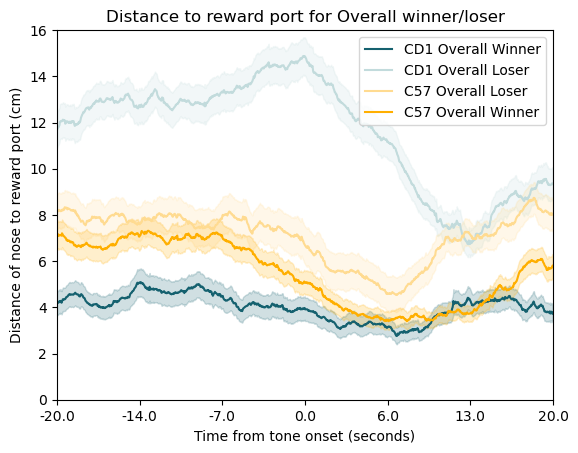

In [154]:
# Add shading for the standard error
plt.plot(cd1_overall_winner_nose_mean_distance, color="#15616F", label="CD1 Overall Winner")
plt.fill_between(range(len(cd1_overall_winner_nose_mean_distance)), cd1_overall_winner_nose_mean_distance - cd1_overall_winner_nose_sem_distance, cd1_overall_winner_nose_mean_distance + cd1_overall_winner_nose_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_overall_loser_nose_mean_distance, color="#C2DBDC", label="CD1 Overall Loser")
plt.fill_between(range(len(cd1_overall_loser_nose_mean_distance)), cd1_overall_loser_nose_mean_distance - cd1_overall_loser_nose_sem_distance, cd1_overall_loser_nose_mean_distance + cd1_overall_loser_nose_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_overall_loser_nose_mean_distance, color="#FFDB91", label="C57 Overall Loser")
plt.fill_between(range(len(c57_overall_loser_nose_mean_distance)), c57_overall_loser_nose_mean_distance - cd1_overall_loser_nose_sem_distance, c57_overall_loser_nose_mean_distance + cd1_overall_loser_nose_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_overall_winner_nose_mean_distance, color="#FFAF00", label="C57 Overall Winner")
plt.fill_between(range(len(c57_overall_winner_nose_mean_distance)), c57_overall_winner_nose_mean_distance - c57_overall_winner_nose_sem_distance, c57_overall_winner_nose_mean_distance + c57_overall_winner_nose_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of nose to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 16)

plt.title("Distance to reward port for Overall winner/loser")

plt.legend()
plt.savefig("./proc/rc_nose_overall_winner_distance.png")

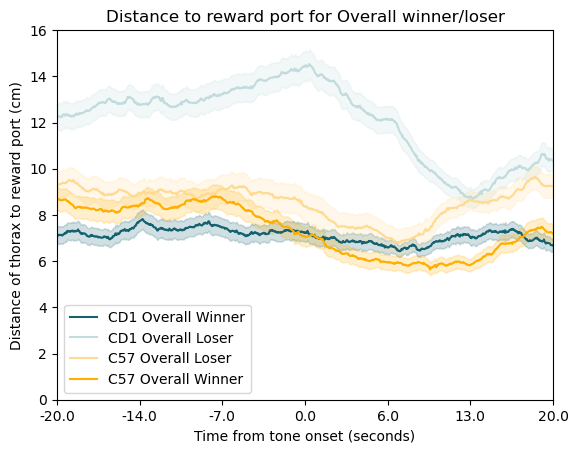

In [155]:
# Add shading for the standard error
plt.plot(cd1_overall_winner_thorax_mean_distance, color="#15616F", label="CD1 Overall Winner")
plt.fill_between(range(len(cd1_overall_winner_thorax_mean_distance)), cd1_overall_winner_thorax_mean_distance - cd1_overall_winner_thorax_sem_distance, cd1_overall_winner_thorax_mean_distance + cd1_overall_winner_thorax_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_overall_loser_thorax_mean_distance, color="#C2DBDC", label="CD1 Overall Loser")
plt.fill_between(range(len(cd1_overall_loser_thorax_mean_distance)), cd1_overall_loser_thorax_mean_distance - cd1_overall_loser_thorax_sem_distance, cd1_overall_loser_thorax_mean_distance + cd1_overall_loser_thorax_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_overall_loser_thorax_mean_distance, color="#FFDB91", label="C57 Overall Loser")
plt.fill_between(range(len(c57_overall_loser_thorax_mean_distance)), c57_overall_loser_thorax_mean_distance - cd1_overall_loser_thorax_sem_distance, c57_overall_loser_thorax_mean_distance + cd1_overall_loser_thorax_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_overall_winner_thorax_mean_distance, color="#FFAF00", label="C57 Overall Winner")
plt.fill_between(range(len(c57_overall_winner_thorax_mean_distance)), c57_overall_winner_thorax_mean_distance - c57_overall_winner_thorax_sem_distance, c57_overall_winner_thorax_mean_distance + c57_overall_winner_thorax_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 16)

plt.title("Distance to reward port for Overall winner/loser")

plt.legend()
plt.savefig("./proc/rc_thorax_overall_winner_distance.png")

In [156]:
TONE_START_DF.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'file_base', 'date',
       'all_subj', 'subj_id', 'subj_index', 'all_tone_frame', 'corner_file',
       'pose_estimation_file', 'corner_sleap', 'box_bottom_left_coordinates',
       'reward_port_coordinates', 'box_bottom_right_coordinates',
       'box_top_left_coordinates', 'box_top_right_coordinates', 'bottom_width',
       'top_width', 'right_height', 'left_height', 'average_height',
       'average_width', 'width_ratio', 'height_ratio', 'reward_port_scaled',
       'pose_estimation_sleap', 'track_names', 'track_id', 'subj_track',
       'pose_estimation_original_coordinates',
       'pose_estimation_scaled_coordinates',
       'pose_estimation_thorax_coordinates',
       'pose_estimation_nose_coordinates', 'thorax_to_reward_port_distance',
       'nose_to_reward_port_distance', 'thorax_to_reward_port_tone_slices',
       'nose_to_reward_port_tone_slices', 'distance_between_subject',
       'all_thorax_velocity', 'rc_trial_number'

In [157]:
distance_and_scoring_df.shape

(62, 83)

In [158]:
TONE_START_DF["all_subj"].unique()

array([('1.1', '1.2'), ('1.3', '1.4'), ('2.1', '2.2'), ('2.2', '2.4'),
       ('2.1', '2.3'), ('1.2', '1.4'), ('1.1', '1.3'), ('3.2', '3.4'),
       ('3.1', '3.3'), ('3.1', '3.4'), ('3.2', '3.3'), ('2.1', '2.4'),
       ('2.2', '2.3'), ('1.1', '1.4'), ('1.2', '1.3'), ('4.1', '4.2'),
       ('4.3', '4.4'), ('6.1', '6.2'), ('6.3', '6.4'), ('5.2', '5.4'),
       ('5.1', '5.3'), ('4.1', '4.4'), ('6.2', '6.3'), ('5.1', '5.4'),
       ('6.1', '6.3'), ('6.2', '6.4')], dtype=object)

In [159]:
distance_and_scoring_df["thorax_to_reward_port_tone_slices"].iloc[0].shape

(20, 1200)